In [1]:
# Cell 1: Section 1 - Initialization: Imports
#
# Import all required libraries for the project.
#

# --- Core Libraries ---
import os
import sys
import logging
import time

# --- Data Handling ---
import pandas as pd
import numpy as np

import findspark
findspark.init()
# --- PySpark Core ---
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, avg, stddev, min, max, sum, lit, broadcast
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.window import Window

# --- PySpark ML (Preprocessing) ---
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation

# --- PySpark ML (Models) ---
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Model Evaluation (Local) ---
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

print("="*80)
print("Cell 1: All libraries imported successfully.")
print(f"PySpark Version: {pyspark.__version__}")
print("="*80)

Cell 1: All libraries imported successfully.
PySpark Version: 2.4.8


In [2]:
# Cell 2: Section 1 - Logging and Path Configuration
#
# Configure logging, define all project paths, and create output directories.
#

# --- 1. Configure Logging ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
log = logging.getLogger("FraudDetectionLogger")
log.info("Logging initialized.")

# --- 2. Define Project Paths ---
try:
    # Get the user's home directory 
    HOME_DIR = '/home/smitvd22' 
    
    # Base project directory
    PROJECT_DIR = os.path.join(HOME_DIR, 'SparkProject')
    
    # --- Local Paths (for initial ingest) ---
    LOCAL_DATASET_PATH = os.path.join(PROJECT_DIR, 'dataset', 'PS_20174392719_1491204439457_log.csv')
    
    # --- HDFS Paths (for all processing) ---
    HDFS_BASE_PATH = f"/user/smitvd22/fraud_detection"
    HDFS_DATA_PATH = f"{HDFS_BASE_PATH}/data/transactions.parquet"
    
    # --- *** NEW: HDFS Paths for intermediate DataFrames *** ---
    HDFS_INTERMEDIATE_PATH = f"{HDFS_BASE_PATH}/intermediate"
    HDFS_PROCESSED_PATH = f"{HDFS_INTERMEDIATE_PATH}/processed.parquet"
    HDFS_UNBALANCED_TRAIN_PATH = f"{HDFS_INTERMEDIATE_PATH}/unbalanced_train.parquet"
    HDFS_TEST_PATH = f"{HDFS_INTERMEDIATE_PATH}/test.parquet"
    HDFS_TRAIN_PATH = f"{HDFS_INTERMEDIATE_PATH}/train_balanced.parquet"
    # --- *** ---
    
    # --- Hive Configuration ---
    HIVE_DB_NAME = "fraud_detection_db"
    HIVE_TABLE_NAME = "transactions"
    
    # --- Output & Model Paths ---
    OUTPUT_DIR = os.path.join(PROJECT_DIR, 'output')
    PLOT_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'plots')
    METRICS_OUTPUT_DIR = os.path.join(OUTPUT_DIR, 'metrics')
    MODEL_OUTPUT_DIR = os.path.join(PROJECT_DIR, 'models') # Save models to local FS
    
    log.info(f"Project Directory: {PROJECT_DIR}")
    log.info(f"Local Dataset: {LOCAL_DATASET_PATH}")
    log.info(f"HDFS Parquet Path: {HDFS_DATA_PATH}")
    log.info(f"HDFS Intermediate Path: {HDFS_INTERMEDIATE_PATH}")

    # --- 3. Create Local Output Directories ---
    os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)
    os.makedirs(METRICS_OUTPUT_DIR, exist_ok=True)
    os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
    
    log.info(f"Created output plot directory: {PLOT_OUTPUT_DIR}")

    # --- 4. Visualization Settings ---
    sns.set_style("whitegrid")
    plt.rcParams['figure.dpi'] = 300
    log.info("Seaborn and Matplotlib configured.")

except Exception as e:
    log.error(f"Error setting up paths: {e}")

print("="*80)
print("Cell 2: Logging and paths configured.")
print("="*80)

2025-11-16 19:29:14 - FraudDetectionLogger - INFO - Logging initialized.
2025-11-16 19:29:14 - FraudDetectionLogger - INFO - Project Directory: /home/smitvd22/SparkProject
2025-11-16 19:29:14 - FraudDetectionLogger - INFO - Local Dataset: /home/smitvd22/SparkProject/dataset/PS_20174392719_1491204439457_log.csv
2025-11-16 19:29:14 - FraudDetectionLogger - INFO - HDFS Parquet Path: /user/smitvd22/fraud_detection/data/transactions.parquet
2025-11-16 19:29:14 - FraudDetectionLogger - INFO - HDFS Intermediate Path: /user/smitvd22/fraud_detection/intermediate
2025-11-16 19:29:14 - FraudDetectionLogger - INFO - Created output plot directory: /home/smitvd22/SparkProject/output/plots
2025-11-16 19:29:14 - FraudDetectionLogger - INFO - Seaborn and Matplotlib configured.


Cell 2: Logging and paths configured.


In [3]:
# Cell 3: Section 1 - Initialize SparkSession
#
# Start the SparkSession with Hive support and configurations 
# for processing a multi-GB dataset.
#

try:
    log.info("Building SparkSession...")
    
    # Suppress Hive warnings
    import warnings
    warnings.filterwarnings('ignore')
    
    spark = (
        SparkSession.builder
        .appName("PySpark_Fraud_Detection_Project")
        .enableHiveSupport()  # Enable integration with Hive Metastore
        
        # --- *** MODIFICATION: Optimized memory for better performance *** ---
        .config("spark.driver.memory", "4g")
        .config("spark.executor.memory", "4g")
        .config("spark.executor.memoryOverhead", "1g")
        .config("spark.driver.memoryOverhead", "1g")
        .config("spark.driver.maxResultSize", "2g")
        
        # Memory management optimizations
        .config("spark.memory.fraction", "0.8")
        .config("spark.memory.storageFraction", "0.3")
        .config("spark.memory.offHeap.enabled", "true")
        .config("spark.memory.offHeap.size", "1g")
        
        # Increase shuffle partitions for better parallelism
        .config("spark.sql.shuffle.partitions", "200")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
        
        # Use a more efficient serializer
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        .config("spark.kryoserializer.buffer.max", "1g")
        
        # Increase heartbeat timeouts to avoid warnings
        .config("spark.executor.heartbeatInterval", "20s")
        .config("spark.network.timeout", "300s")
        
        # Suppress Hive warnings
        .config("spark.sql.hive.verifyPartitionPath", "false")
        
        # Garbage collection optimizations
        .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:+UnlockDiagnosticVMOptions -XX:+G1PrintRegionRememberedSetInfo")
        .config("spark.driver.extraJavaOptions", "-XX:+UseG1GC -XX:+UnlockDiagnosticVMOptions")
        
        .getOrCreate()
    )
    
    sc = spark.sparkContext
    # Set log level to reduce noise
    sc.setLogLevel("ERROR")
    
    log.info("SparkSession created successfully.")
    log.info(f"Spark UI available at: {sc.uiWebUrl}")

    # --- Create Hive Database (with error handling) ---
    # Check if database exists first
    databases = spark.sql("SHOW DATABASES").collect()
    db_exists = any(row['databaseName'] == HIVE_DB_NAME for row in databases)
    
    if not db_exists:
        spark.sql(f"CREATE DATABASE {HIVE_DB_NAME}")
        log.info(f"Created Hive database '{HIVE_DB_NAME}'.")
    else:
        log.info(f"Hive database '{HIVE_DB_NAME}' already exists.")
    
    spark.sql(f"USE {HIVE_DB_NAME}")
    log.info(f"Using Hive database '{HIVE_DB_NAME}'.")
    
    # --- *** NEW: Create HDFS directory for intermediate files *** ---
    fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
    hdfs_path = spark._jvm.org.apache.hadoop.fs.Path(HDFS_INTERMEDIATE_PATH)
    if not fs.exists(hdfs_path):
        fs.mkdirs(hdfs_path)
        log.info(f"Created HDFS directory: {HDFS_INTERMEDIATE_PATH}")

except Exception as e:
    log.error(f"Error initializing SparkSession: {e}")
    raise e

print("="*80)
print("Cell 3: SparkSession initialized with Hive support.")
print("="*80)

2025-11-16 19:29:14 - FraudDetectionLogger - INFO - Building SparkSession...
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/spark/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/smitvd22/hadoop-2.6.5/share/hadoop/common/lib/slf4j-log4j12-1.7.5.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
25/11/16 19:29:19 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2025-11-16 19:29:25 - FraudDetectionLogger - INFO - SparkSession created successfully.
2025-11-16 19:29:25 - FraudDetectionLogger - INFO - Spark UI available at: http:/

Cell 3: SparkSession initialized with Hive support.


In [4]:
# Cell 4: Section 2 - Data Ingest (Local CSV -> HDFS Parquet)
#
# Phase 1: Load the large local CSV, define the schema,
# and write it to HDFS in the optimized Parquet format.
#

try:
    log.info(f"Starting Phase 1: Ingesting local CSV from {LOCAL_DATASET_PATH}")
    
    # Define the schema to avoid slow 'inferSchema' on 6M rows
    schema = StructType([
        StructField("step", IntegerType(), True),
        StructField("type", StringType(), True),
        StructField("amount", DoubleType(), True),
        StructField("nameOrig", StringType(), True),
        StructField("oldbalanceOrg", DoubleType(), True),
        StructField("newbalanceOrig", DoubleType(), True),
        StructField("nameDest", StringType(), True),
        StructField("oldbalanceDest", DoubleType(), True),
        StructField("newbalanceDest", DoubleType(), True),
        StructField("isFraud", IntegerType(), True),
        StructField("isFlaggedFraud", IntegerType(), True)
    ])

    # Read from LOCAL filesystem (note the 'file://' prefix)
    df_raw = spark.read.csv(
        f"file://{LOCAL_DATASET_PATH}",
        header=True,
        schema=schema
    )
    
    log.info("Local CSV read successfully. Writing to HDFS Parquet...")

    # Write to HDFS in Parquet format. This is much faster for analysis.
    # 'overwrite' mode allows us to re-run this notebook
    df_raw.write.mode("overwrite").parquet(HDFS_DATA_PATH)
    
    log.info(f"Phase 1 Complete: Data written to HDFS at {HDFS_DATA_PATH}")

except Exception as e:
    log.error(f"Error during data ingest: {e}")
    log.error("Did you start HDFS? (e.g., /hadoop-2.6.5/sbin/start-dfs.sh)")
    raise e

print("="*80)
print("Cell 4: Data ingested from local CSV and saved to HDFS as Parquet.")
print("="*80)

2025-11-16 19:29:35 - FraudDetectionLogger - INFO - Starting Phase 1: Ingesting local CSV from /home/smitvd22/SparkProject/dataset/PS_20174392719_1491204439457_log.csv
2025-11-16 19:29:35 - FraudDetectionLogger - INFO - Local CSV read successfully. Writing to HDFS Parquet...
2025-11-16 19:30:22 - FraudDetectionLogger - INFO - Phase 1 Complete: Data written to HDFS at /user/smitvd22/fraud_detection/data/transactions.parquet


Cell 4: Data ingested from local CSV and saved to HDFS as Parquet.


In [5]:
# Cell 5: Section 2 - Load Data from HDFS
#
# Phase 2: All subsequent work will use the fast, distributed HDFS Parquet file.
#

try:
    log.info(f"Starting Phase 2: Loading Parquet data from HDFS: {HDFS_DATA_PATH}")
    
    df = spark.read.parquet(HDFS_DATA_PATH)
    
    # --- *** MODIFICATION: Removed persist() *** ---
    # We will re-read this file from HDFS as needed.
    
    # Trigger an action to load the data and log the count
    total_records = df.count()
    log.info(f"Successfully loaded {total_records} records from HDFS Parquet.")

except Exception as e:
    log.error(f"Error loading HDFS Parquet file: {e}")
    raise e

print("="*80)
print(f"Cell 5: Successfully loaded {total_records} records from HDFS.")
print("="*80)

2025-11-16 19:30:22 - FraudDetectionLogger - INFO - Starting Phase 2: Loading Parquet data from HDFS: /user/smitvd22/fraud_detection/data/transactions.parquet
2025-11-16 19:30:24 - FraudDetectionLogger - INFO - Successfully loaded 6362620 records from HDFS Parquet.


Cell 5: Successfully loaded 6362620 records from HDFS.


In [6]:
# Cell 6: Section 2 - Schema and First Look
try:
    log.info("Displaying DataFrame schema:")
    df.printSchema()
    
    log.info("Displaying first 20 records:")
    df.show(20, truncate=False)
    
except Exception as e:
    log.error(f"Error displaying schema or data: {e}")

print("="*80)
print("Cell 6: Schema and sample data displayed.")
print("="*80)

2025-11-16 19:30:24 - FraudDetectionLogger - INFO - Displaying DataFrame schema:
2025-11-16 19:30:25 - FraudDetectionLogger - INFO - Displaying first 20 records:


root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|type    |amount   |nameOrig   |oldbalanceOrg|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|21  |CASH_IN |56224.65 |C1466318501|1.085097837E7|1.090720301E7 |C35088813  |142844.05     |86619.4       |0      |0             |
|21  

In [7]:
# Cell 7: Section 2 - Null Value Check
#
# Check for null or NaN values in all columns.
#

try:
    log.info("Checking for null values...")
    
    # Create an expression for each column to count nulls
    from pyspark.sql.functions import count, when, isnan, col
    
    null_counts = df.select([
        count(when(isnan(c) | col(c).isNull(), c)).alias(c) 
        for c in df.columns
    ])
    
    log.info("Null value counts per column:")
    null_counts.show()
    
    # This will be a 1-row DataFrame. Collect it to print a summary.
    null_counts_pd = null_counts.collect()[0].asDict()
    
    # Use Python's built-in sum function directly (avoid name conflict)
    import builtins
    total_nulls = builtins.sum(null_counts_pd.values())
    
    if total_nulls == 0:
        log.info("PASSED: No null or NaN values found in the dataset.")
    else:
        log.warning(f"WARNING: Found {total_nulls} total null/NaN values.")

except Exception as e:
    log.error(f"Error checking for null values: {e}")

print("="*80)
print("Cell 7: Null value check complete.")
print("="*80)

2025-11-16 19:30:25 - FraudDetectionLogger - INFO - Checking for null values...
2025-11-16 19:30:26 - FraudDetectionLogger - INFO - Null value counts per column:


+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



2025-11-16 19:30:45 - FraudDetectionLogger - INFO - PASSED: No null or NaN values found in the dataset.


Cell 7: Null value check complete.


In [8]:
# Cell 8: Section 2 - Basic Statistics
#
# Calculate descriptive statistics for key numerical columns.
#

try:
    log.info("Calculating descriptive statistics...")
    
    numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
    
    stats = df.describe(numeric_cols)
    stats.show()

except Exception as e:
    log.error(f"Error calculating statistics: {e}")

print("="*80)
print("Cell 8: Descriptive statistics calculated.")
print("="*80)

2025-11-16 19:30:45 - FraudDetectionLogger - INFO - Calculating descriptive statistics...


+-------+-----------------+-----------------+------------------+------------------+------------------+
|summary|           amount|    oldbalanceOrg|    newbalanceOrig|    oldbalanceDest|    newbalanceDest|
+-------+-----------------+-----------------+------------------+------------------+------------------+
|  count|          6362620|          6362620|           6362620|           6362620|           6362620|
|   mean|179861.9035491319|833883.1040744885| 855113.6685785908|1100701.6665196423|1224996.3982019203|
| stddev|603858.2314629348| 2888242.67303756|2924048.5029542707| 3399180.112994465|3674128.9421196496|
|    min|              0.0|              0.0|               0.0|               0.0|               0.0|
|    max|    9.244551664E7|    5.958504037E7|     4.958504037E7|    3.5601588935E8|    3.5617927892E8|
+-------+-----------------+-----------------+------------------+------------------+------------------+

Cell 8: Descriptive statistics calculated.


In [9]:
# Cell 9: Section 3 (EDA) - Create Hive Table
#
# Create a managed Hive table for SQL-based analysis.
#

try:
    log.info(f"Creating Hive table '{HIVE_TABLE_NAME}' in database '{HIVE_DB_NAME}'...")
    
    # Save the DataFrame as a managed table in Hive
    df.write.mode("overwrite").saveAsTable(f"{HIVE_DB_NAME}.{HIVE_TABLE_NAME}")
    
    log.info("Hive table created successfully.")
    
    # Verify by showing tables
    spark.sql(f"USE {HIVE_DB_NAME}")
    spark.sql("SHOW TABLES").show()

except Exception as e:
    log.error(f"Error creating Hive table: {e}")
    raise e

print("="*80)
print(f"Cell 9: Hive table '{HIVE_TABLE_NAME}' created.")
print("="*80)

2025-11-16 19:30:49 - FraudDetectionLogger - INFO - Creating Hive table 'transactions' in database 'fraud_detection_db'...
2025-11-16 19:31:15 - FraudDetectionLogger - INFO - Hive table created successfully.


+------------------+------------+-----------+
|          database|   tableName|isTemporary|
+------------------+------------+-----------+
|fraud_detection_db|transactions|      false|
+------------------+------------+-----------+

Cell 9: Hive table 'transactions' created.


In [10]:
# Cell 10: Section 3 (EDA) - Class Imbalance (SQL)
#
# Analyze the distribution of fraud vs. normal transactions.
#

try:
    log.info("Analyzing class imbalance using Hive SQL...")
    
    sql_query = f"""
    SELECT 
        isFraud, 
        COUNT(*) as count,
        (COUNT(*) / (SELECT COUNT(*) FROM {HIVE_TABLE_NAME})) * 100 as percentage
    FROM {HIVE_TABLE_NAME}
    GROUP BY isFraud
    """
    
    imbalance_df = spark.sql(sql_query)
    imbalance_df.show()
    
    # Collect the small result to calculate imbalance ratio
    imbalance_data = imbalance_df.collect()
    
    count_normal = 0
    count_fraud = 0
    
    for row in imbalance_data:
        if row['isFraud'] == 0:
            count_normal = row['count']
        else:
            count_fraud = row['count']
            
    fraud_rate = (count_fraud / total_records) * 100
    imbalance_ratio = count_normal / count_fraud
    
    log.info(f"Total Records: {total_records}")
    log.info(f"Normal (0): {count_normal} | Fraud (1): {count_fraud}")
    log.info(f"Fraud Rate: {fraud_rate:.4f}%")
    log.info(f"Imbalance Ratio (Normal:Fraud): {imbalance_ratio:.2f} : 1")
    
    # Save for plotting
    plot_data_imbalance = imbalance_df.toPandas()

except Exception as e:
    log.error(f"Error analyzing class imbalance: {e}")

print("="*80)
print(f"Cell 10: Class imbalance analyzed. Fraud Rate: {fraud_rate:.4f}%.")
print("="*80)

2025-11-16 19:31:15 - FraudDetectionLogger - INFO - Analyzing class imbalance using Hive SQL...


+-------+-------+-------------------+
|isFraud|  count|         percentage|
+-------+-------+-------------------+
|      1|   8213|0.12908204481801522|
|      0|6354407|  99.87091795518198|
+-------+-------+-------------------+



2025-11-16 19:31:30 - FraudDetectionLogger - INFO - Total Records: 6362620      
2025-11-16 19:31:30 - FraudDetectionLogger - INFO - Normal (0): 6354407 | Fraud (1): 8213
2025-11-16 19:31:30 - FraudDetectionLogger - INFO - Fraud Rate: 0.1291%
2025-11-16 19:31:30 - FraudDetectionLogger - INFO - Imbalance Ratio (Normal:Fraud): 773.70 : 1


Cell 10: Class imbalance analyzed. Fraud Rate: 0.1291%.


2025-11-16 19:31:30 - FraudDetectionLogger - INFO - Plotting class distribution...
2025-11-16 19:31:31 - FraudDetectionLogger - INFO - Saved class distribution plot to /home/smitvd22/SparkProject/output/plots/01_class_distribution.png


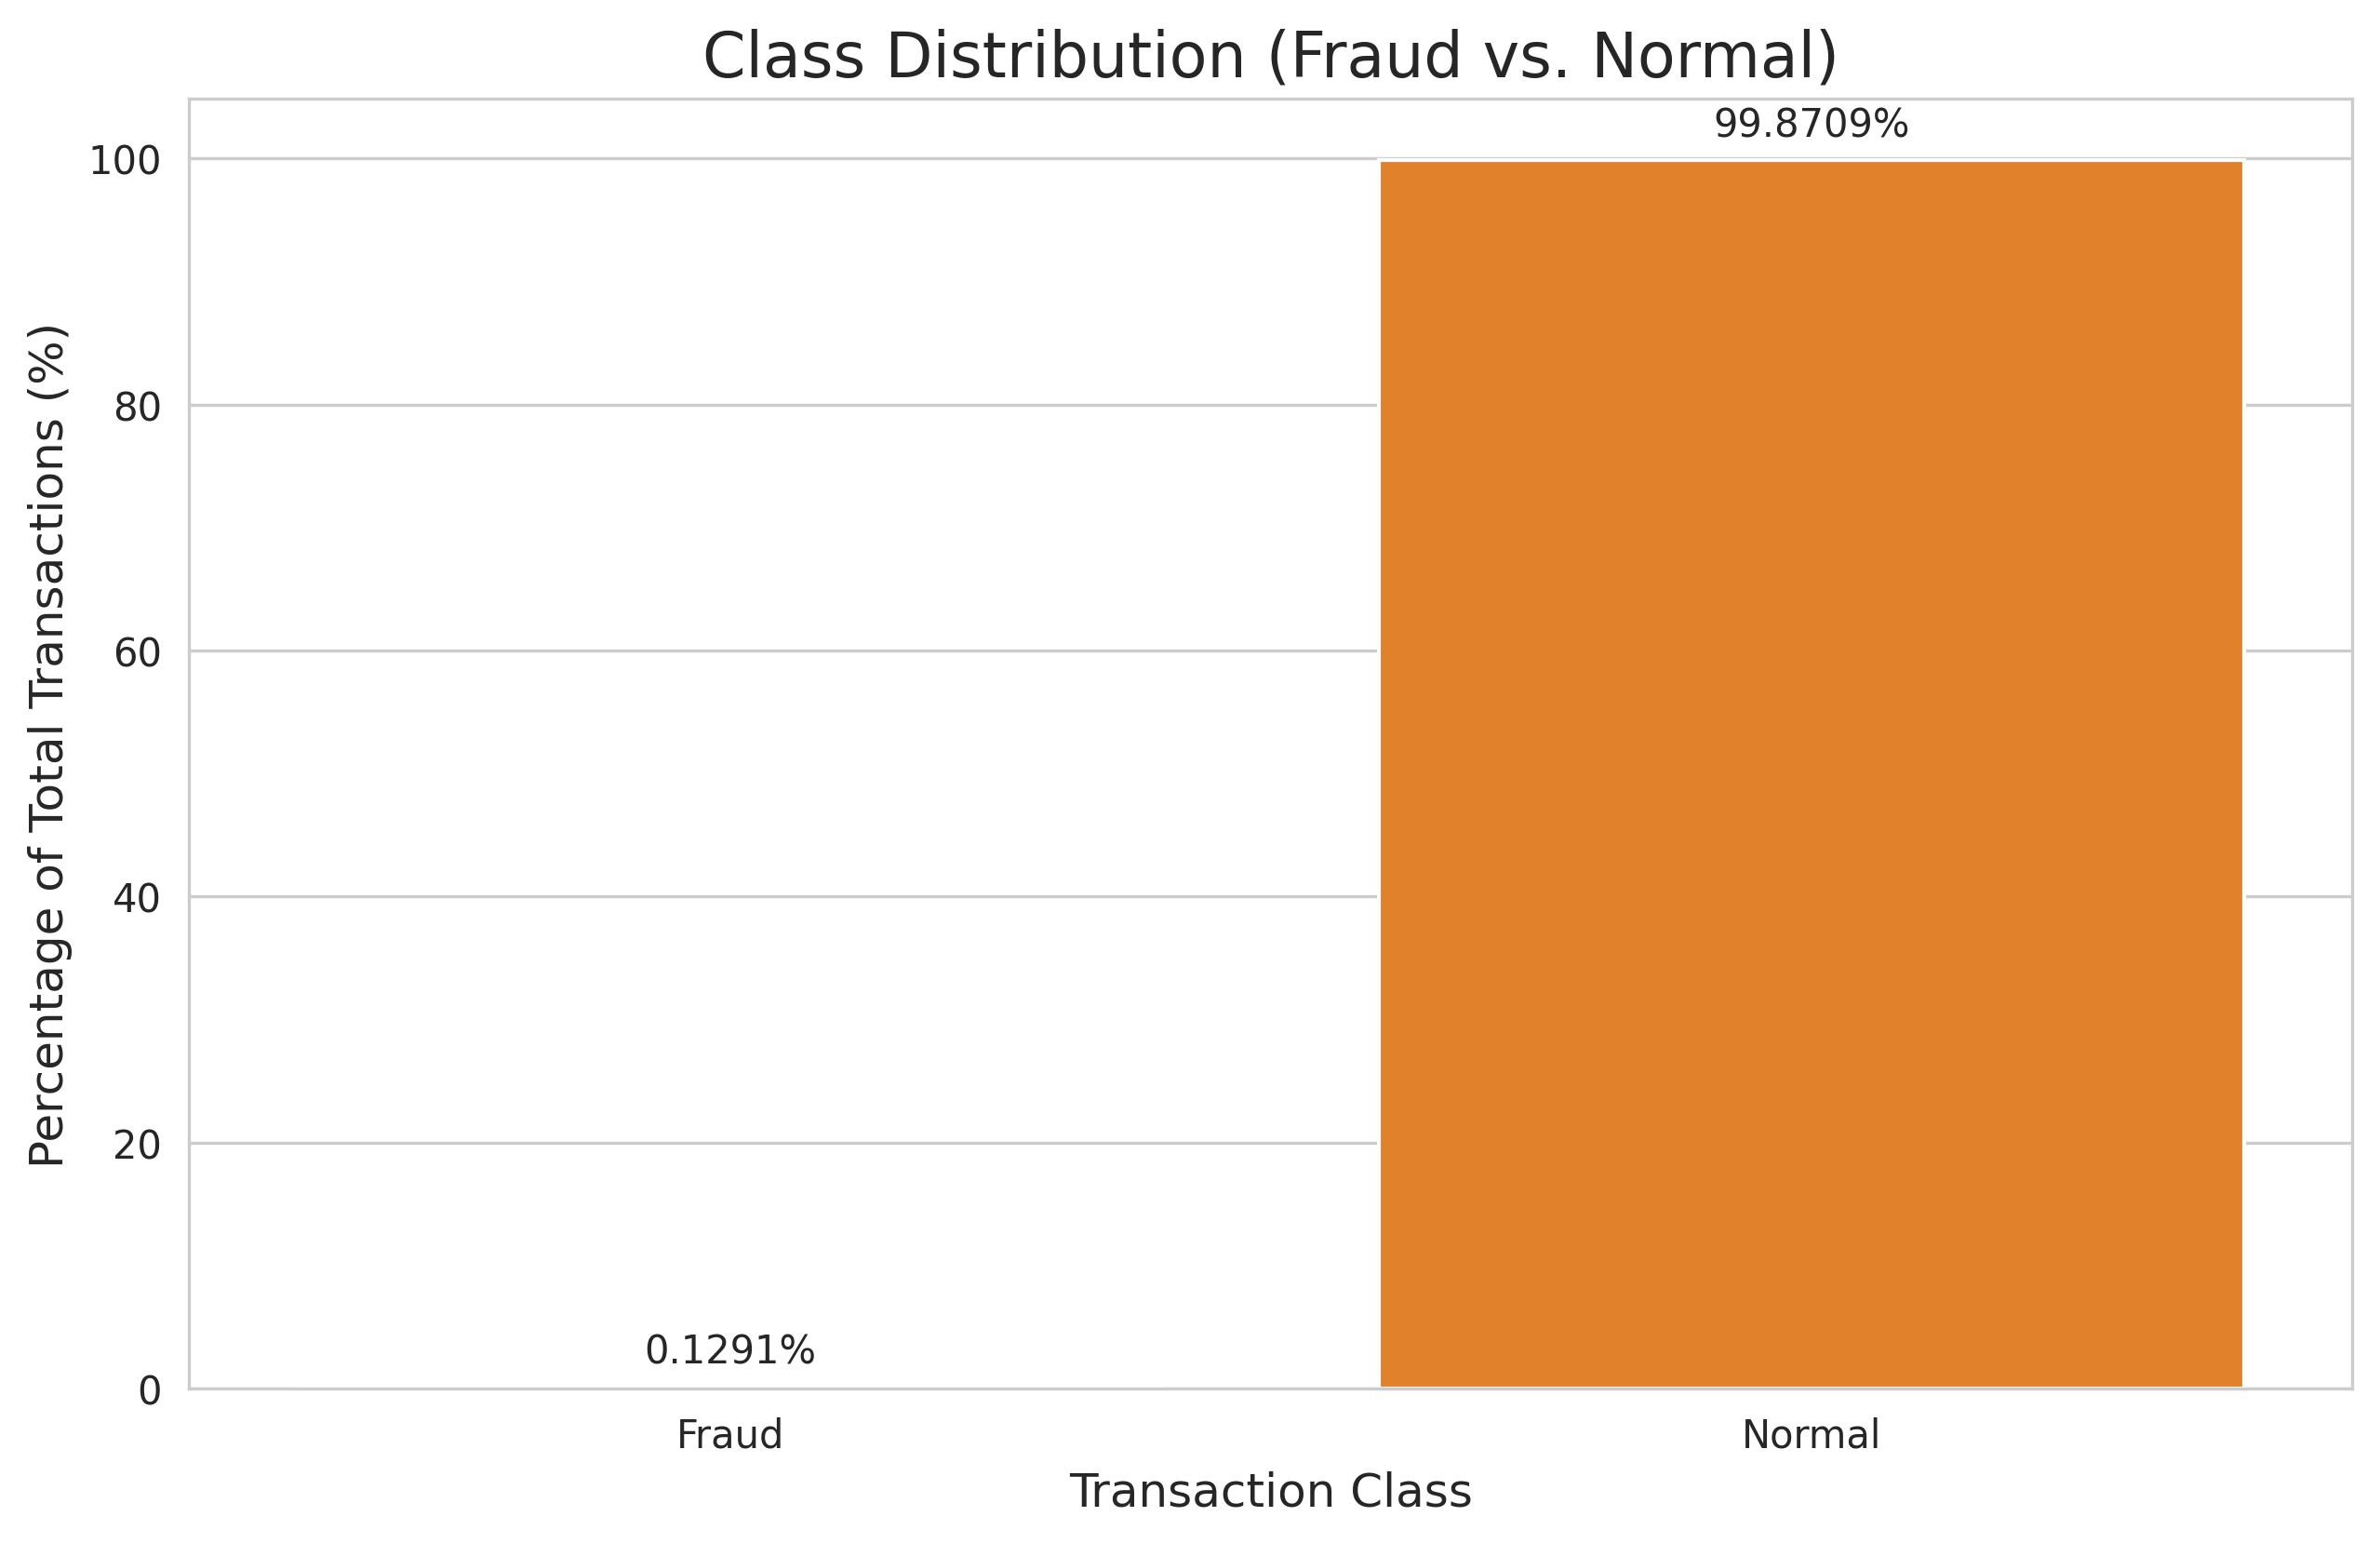

Cell 11: Class distribution plot generated.


In [11]:
# Cell 11: Section 3 (EDA) - Class Imbalance (Visualization)

try:
    log.info("Plotting class distribution...")
    plt.figure(figsize=(10, 6))
    
    ax = sns.barplot(
        x=plot_data_imbalance['isFraud'].map({0: 'Normal', 1: 'Fraud'}), 
        y=plot_data_imbalance['percentage']
    )
    
    ax.set_title('Class Distribution (Fraud vs. Normal)', fontsize=16)
    ax.set_xlabel('Transaction Class', fontsize=12)
    ax.set_ylabel('Percentage of Total Transactions (%)', fontsize=12)
    
    # Add text labels
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.4f}%", 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='center', 
            xytext=(0, 9), 
            textcoords='offset points'
        )
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '01_class_distribution.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved class distribution plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error plotting class distribution: {e}")

print("="*80)
print("Cell 11: Class distribution plot generated.")
print("="*80)

In [12]:
# Cell 12: Section 3 (EDA) - Fraud by Transaction Type (SQL)

try:
    log.info("Analyzing fraud statistics by transaction type using Hive SQL...")
    
    sql_query = f"""
    SELECT 
        type, 
        COUNT(*) as total_transactions,
        SUM(isFraud) as total_fraud,
        (SUM(isFraud) / COUNT(*)) * 100 as fraud_percentage_of_type,
        (SUM(isFraud) / (SELECT SUM(isFraud) FROM {HIVE_TABLE_NAME})) * 100 as percentage_of_all_fraud
    FROM {HIVE_TABLE_NAME}
    GROUP BY type
    ORDER BY total_fraud DESC
    """
    
    type_fraud_df = spark.sql(sql_query)
    
    log.info("Fraud Statistics by Transaction Type:")
    type_fraud_df.show()
    
    # Key Insight
    log.warning("KEY INSIGHT: Note which transaction types have 0 fraud.")
    
    # Save for plotting
    plot_data_type = type_fraud_df.toPandas()

except Exception as e:
    log.error(f"Error analyzing fraud by type: {e}")

print("="*80)
print("Cell 12: Fraud statistics by transaction type calculated.")
print("="*80)

2025-11-16 19:31:31 - FraudDetectionLogger - INFO - Analyzing fraud statistics by transaction type using Hive SQL...
2025-11-16 19:31:31 - FraudDetectionLogger - INFO - Fraud Statistics by Transaction Type:
2025-11-16 19:31:36 - FraudDetectionLogger - WARNING - KEY INSIGHT: Note which transaction types have 0 fraud.


+--------+------------------+-----------+------------------------+-----------------------+
|    type|total_transactions|total_fraud|fraud_percentage_of_type|percentage_of_all_fraud|
+--------+------------------+-----------+------------------------+-----------------------+
|CASH_OUT|           2237500|       4116|     0.18395530726256984|      50.11567027882625|
|TRANSFER|            532909|       4097|      0.7687991758442811|      49.88432972117375|
| CASH_IN|           1399284|          0|                     0.0|                    0.0|
| PAYMENT|           2151495|          0|                     0.0|                    0.0|
|   DEBIT|             41432|          0|                     0.0|                    0.0|
+--------+------------------+-----------+------------------------+-----------------------+



[Stage 31:=================================>                       (7 + 5) / 12]

Cell 12: Fraud statistics by transaction type calculated.


2025-11-16 19:31:40 - FraudDetectionLogger - INFO - Plotting fraud by transaction type...
2025-11-16 19:31:42 - FraudDetectionLogger - INFO - Saved fraud by type plot to /home/smitvd22/SparkProject/output/plots/02_fraud_by_type.png


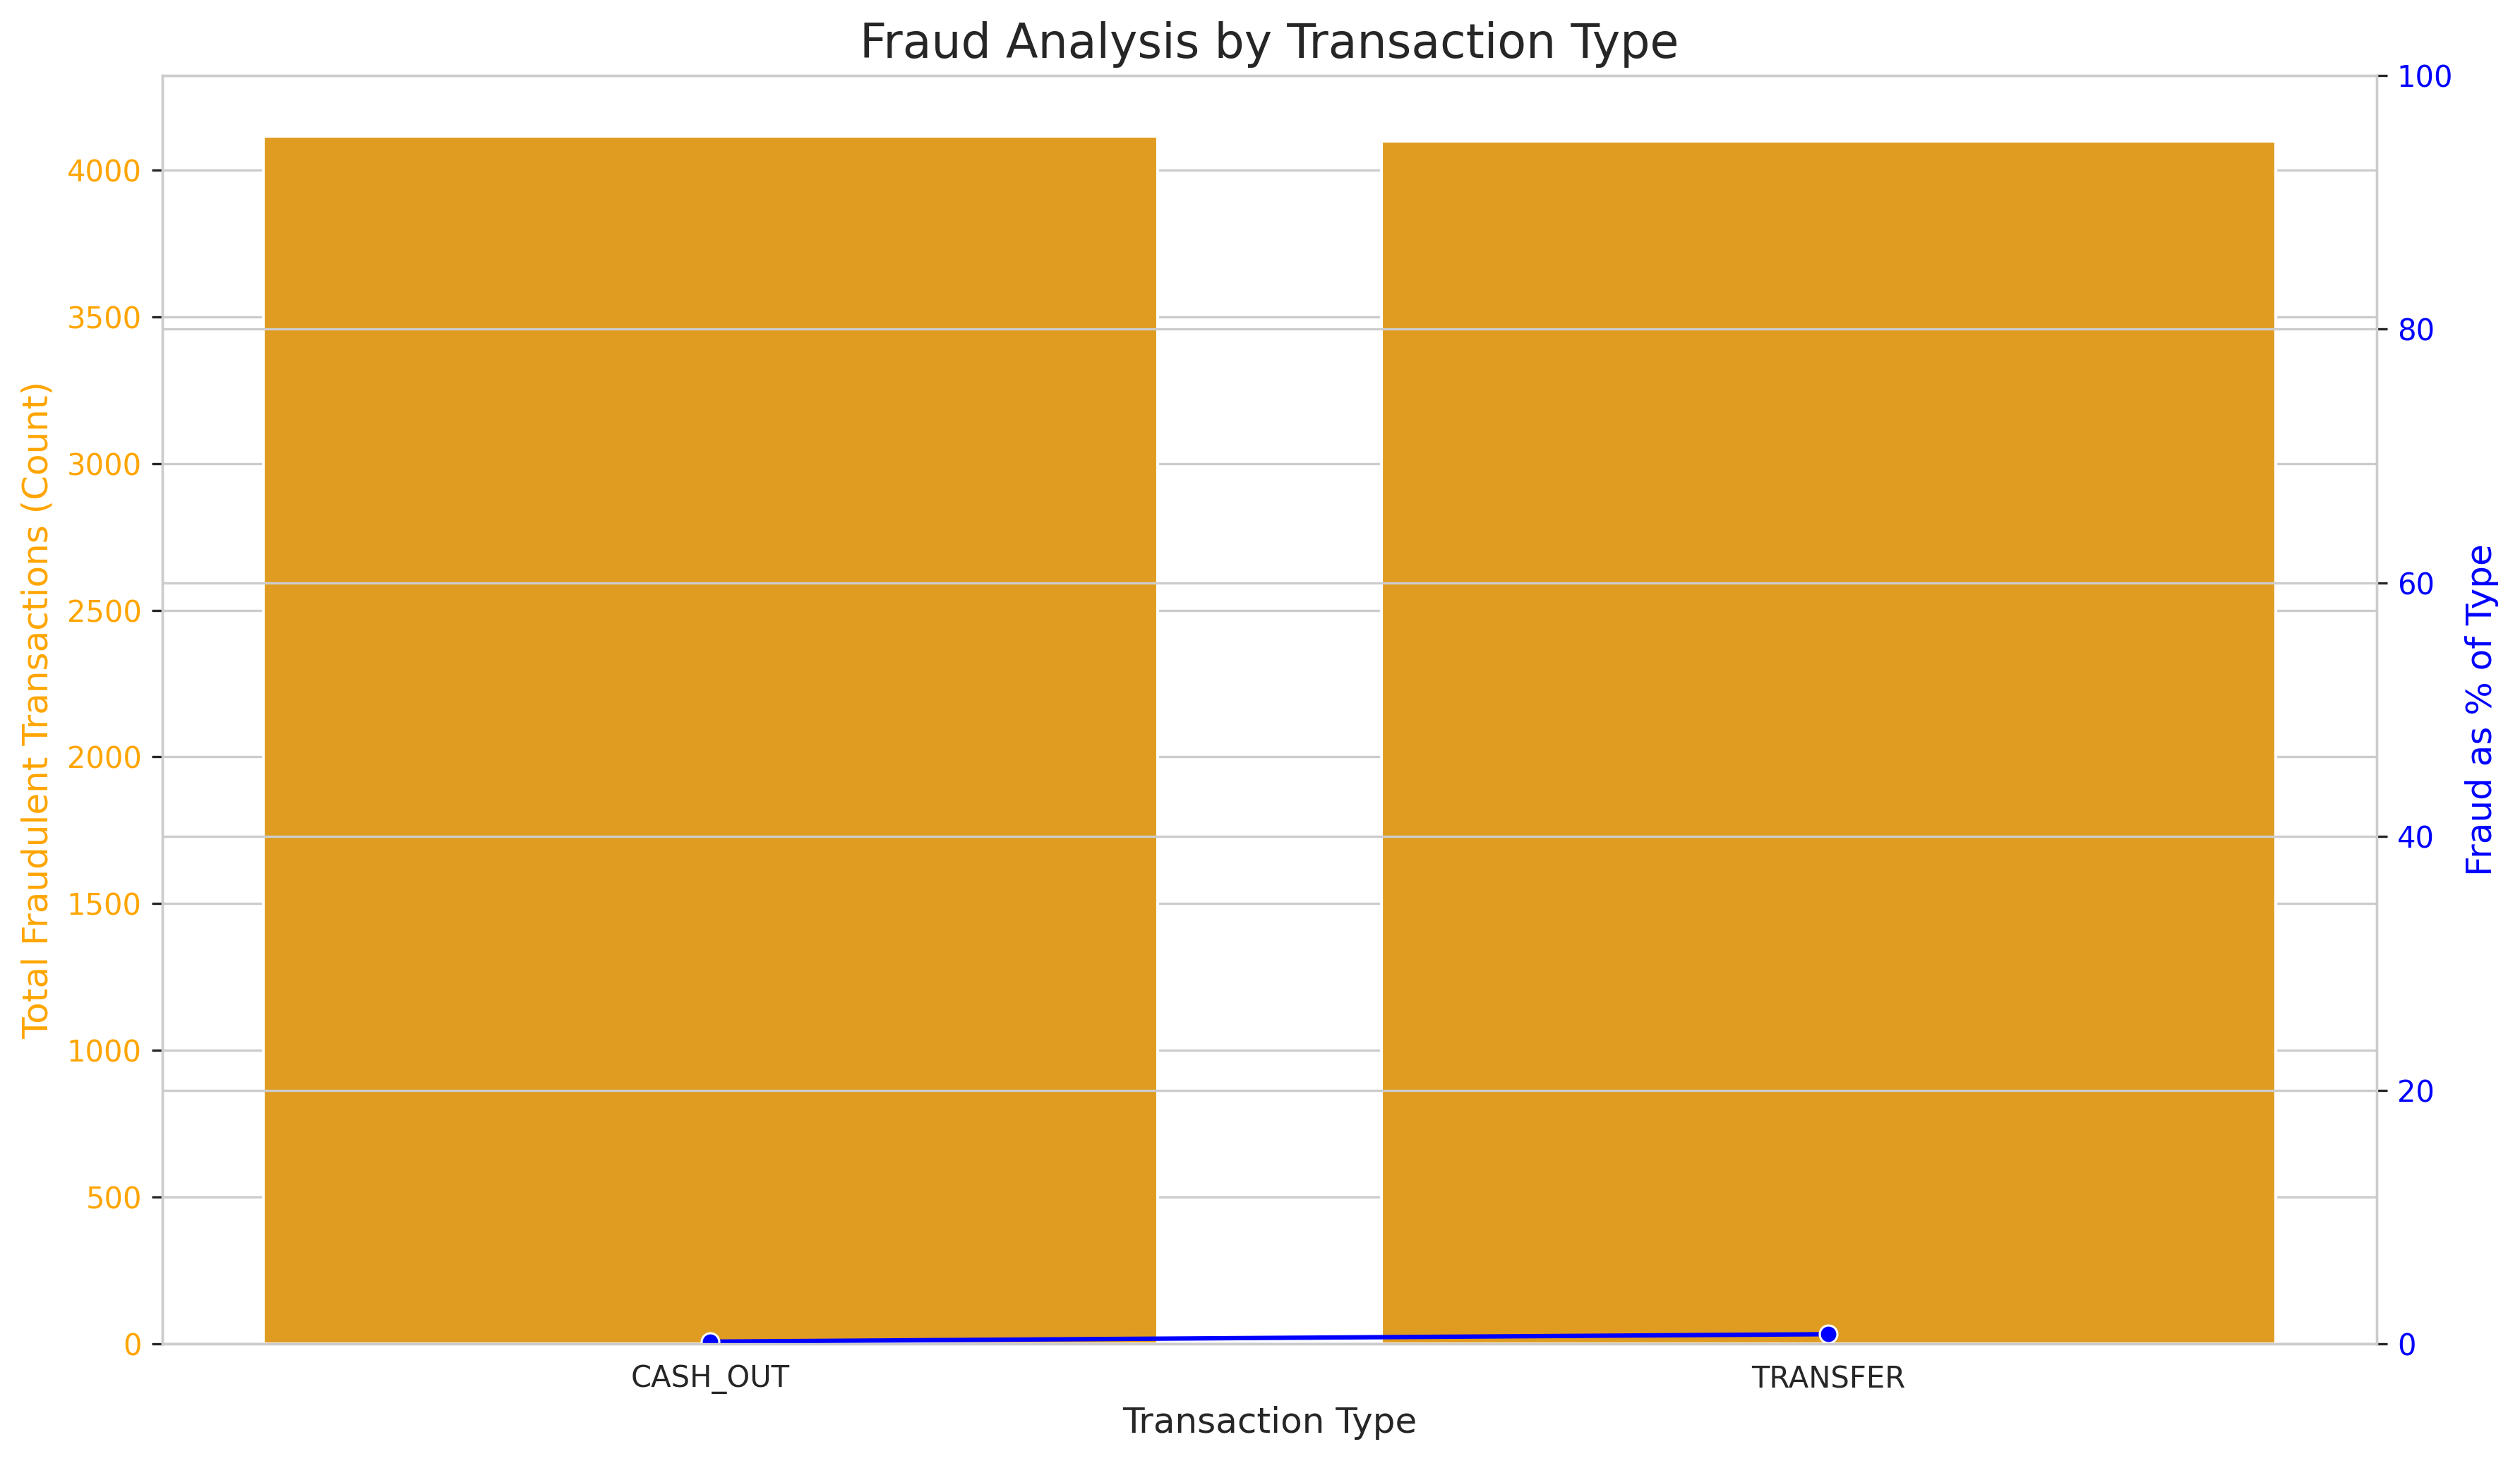

Cell 13: Fraud by transaction type plot generated.


In [13]:
# Cell 13: Section 3 (EDA) - Fraud by Type (Visualization)

try:
    log.info("Plotting fraud by transaction type...")
    
    # Filter for plotting, as non-fraud types dominate
    plot_data_type_fraud = plot_data_type[plot_data_type['total_fraud'] > 0]
    
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Bar plot for total fraud count
    sns.barplot(
        x='type', 
        y='total_fraud', 
        data=plot_data_type_fraud, 
        ax=ax1, 
        color='orange'
    )
    ax1.set_xlabel('Transaction Type', fontsize=12)
    ax1.set_ylabel('Total Fraudulent Transactions (Count)', fontsize=12, color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')

    # Line plot for fraud percentage
    ax2 = ax1.twinx()
    sns.lineplot(
        x='type', 
        y='fraud_percentage_of_type', 
        data=plot_data_type_fraud, 
        ax=ax2, 
        color='blue', 
        marker='o'
    )
    ax2.set_ylabel('Fraud as % of Type', fontsize=12, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(0, 100) # Percentage
    
    plt.title('Fraud Analysis by Transaction Type', fontsize=16)
    fig.tight_layout()
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '02_fraud_by_type.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved fraud by type plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error plotting fraud by type: {e}")

print("="*80)
print("Cell 13: Fraud by transaction type plot generated.")
print("="*80)

2025-11-16 19:31:42 - FraudDetectionLogger - INFO - Analyzing transaction amount distributions...
2025-11-16 19:31:46 - FraudDetectionLogger - INFO - Fraud Amount Stats:         
count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64
2025-11-16 19:31:50 - FraudDetectionLogger - INFO - Normal Amount Stats (from 1% sample):
count    6.393800e+04
mean     1.748771e+05
std      4.973616e+05
min      4.200000e-01
25%      1.313545e+04
50%      7.366443e+04
75%      2.078433e+05
max      3.901816e+07
Name: amount, dtype: float64
2025-11-16 19:31:51 - FraudDetectionLogger - INFO - Saved amount distribution plot to /home/smitvd22/SparkProject/output/plots/03_amount_distribution_log.png


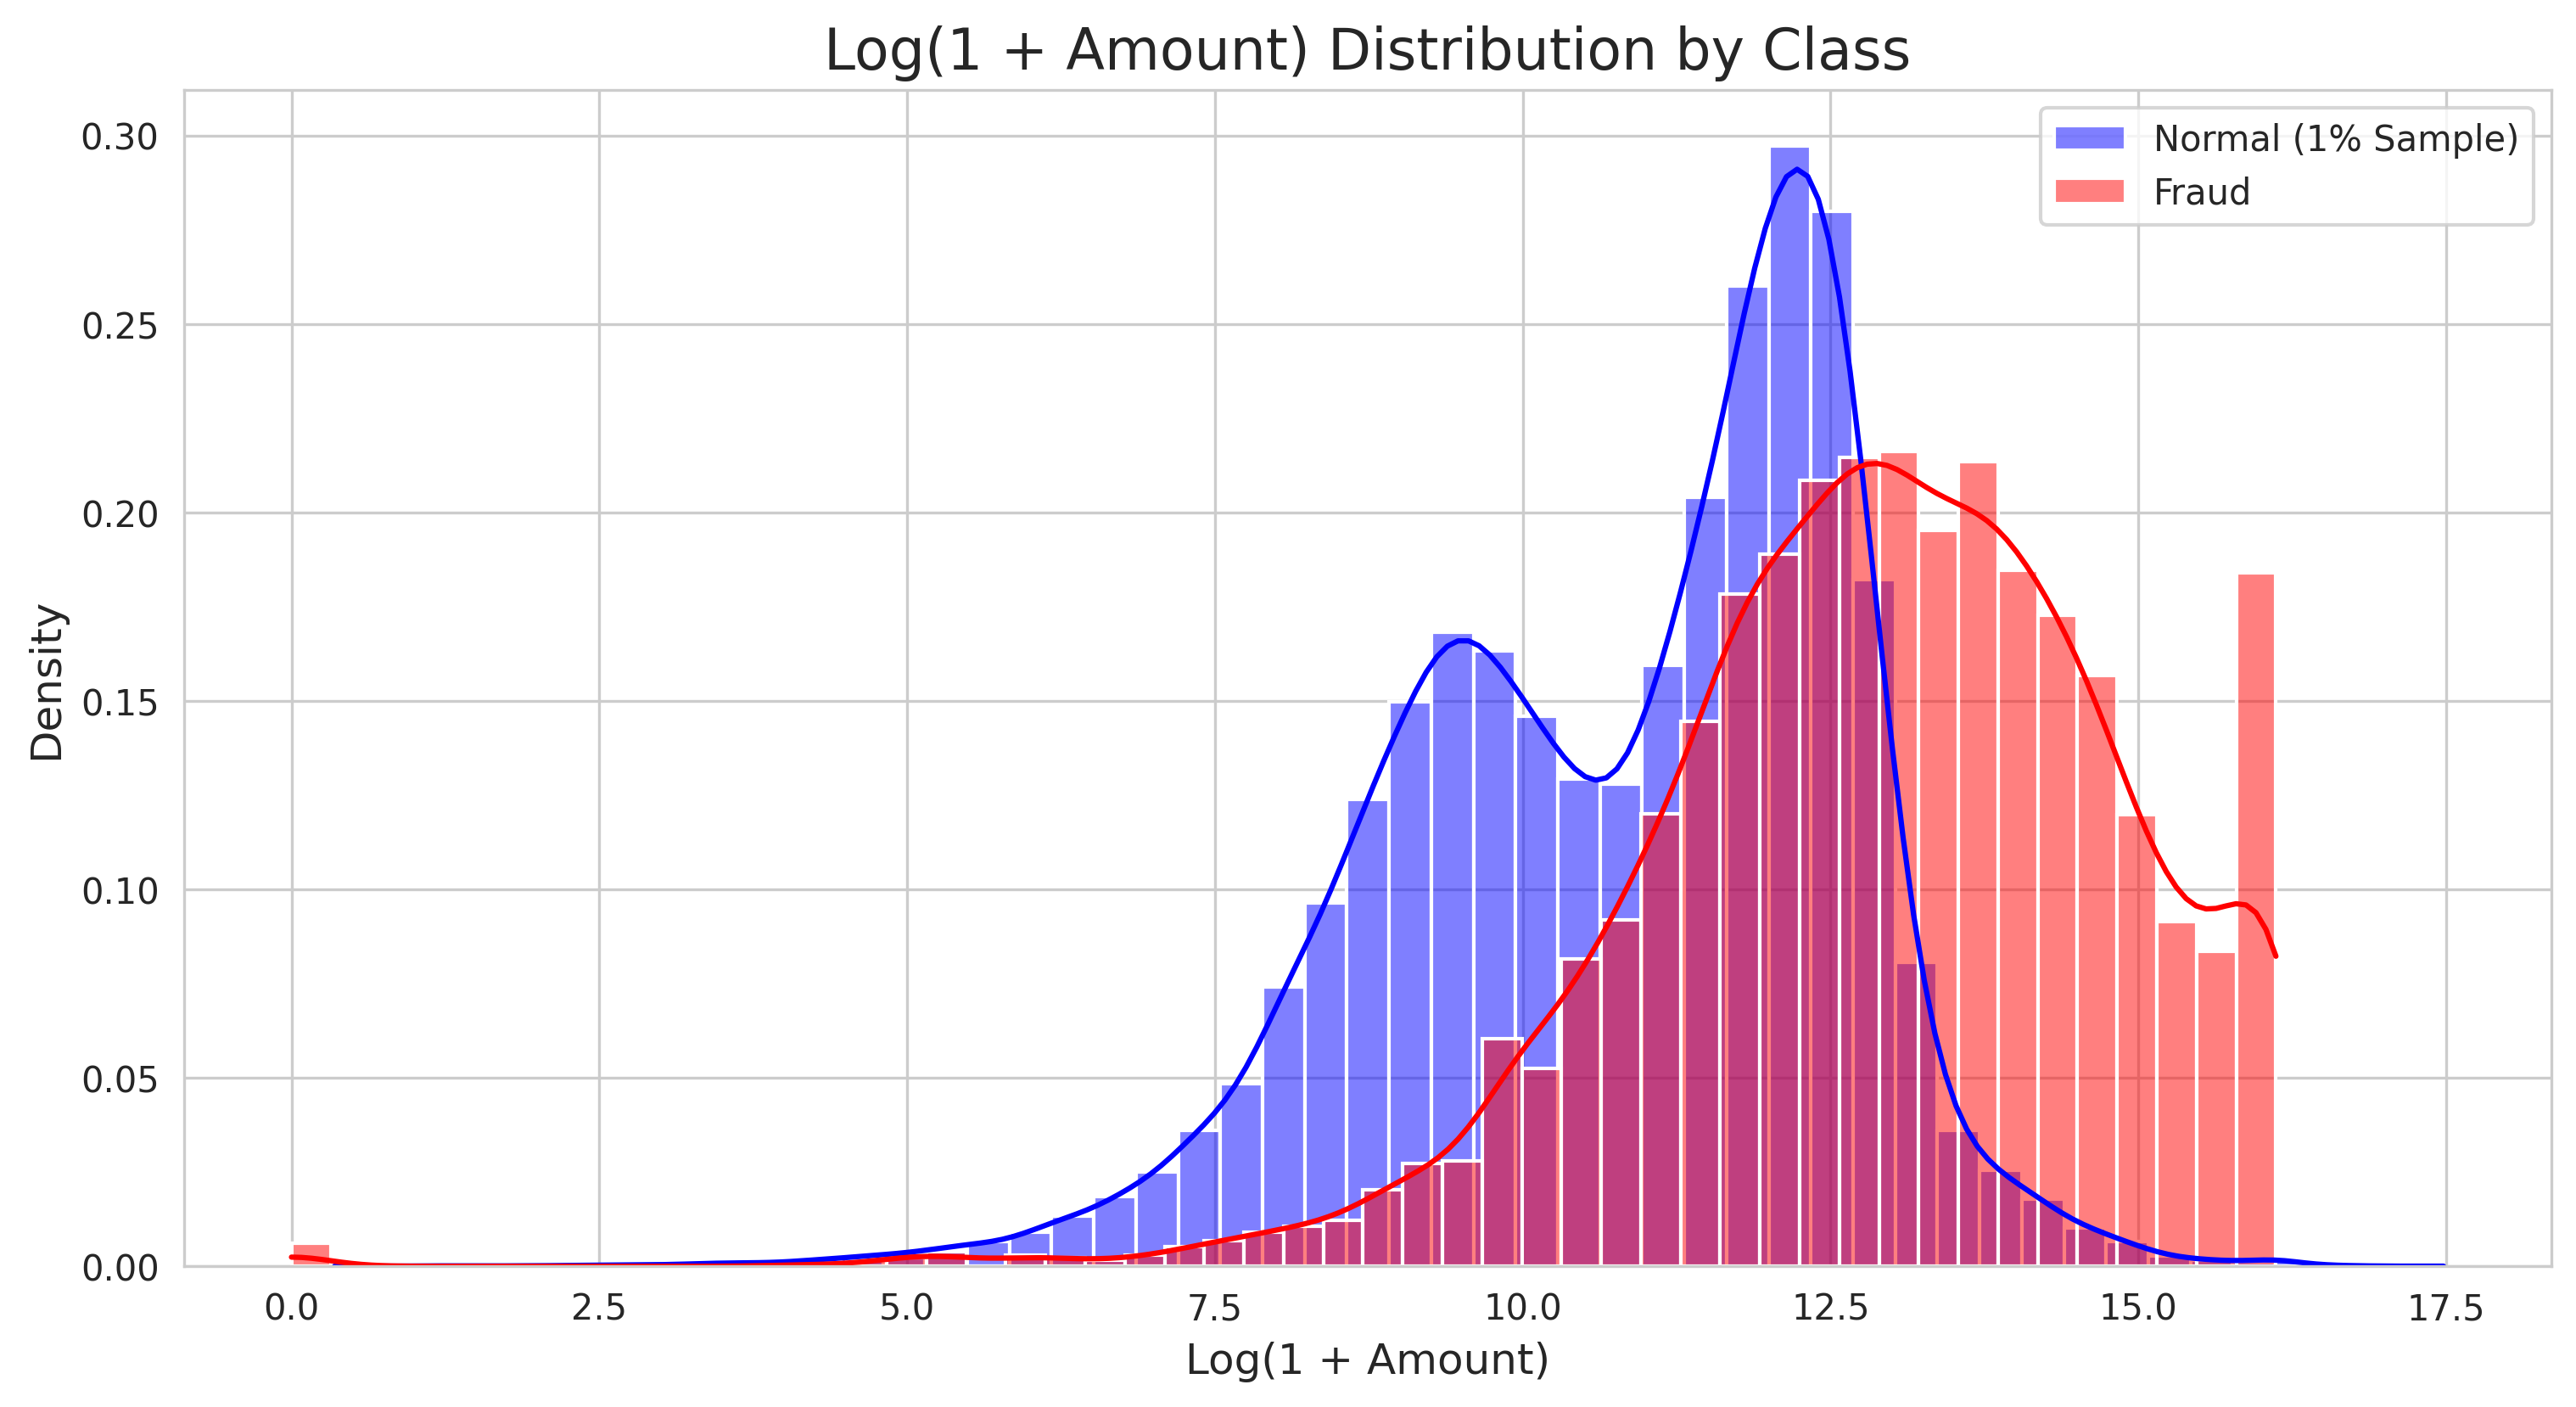

Cell 14: Amount distribution analysis complete.


In [14]:
# Cell 14: Section 3 (EDA) - Amount Distribution (Pandas Sample)
#
# Sample data to plot distributions, as plotting 6.3M points is too slow.
#

try:
    log.info("Analyzing transaction amount distributions...")
    
    # Get all fraud transactions (small enough to collect)
    df_fraud = df.filter(col("isFraud") == 1).toPandas()
    log.info(f"Fraud Amount Stats:\n{df_fraud['amount'].describe()}")
    
    # Get a sample of normal transactions
    df_normal_sample = df.filter(col("isFraud") == 0).sample(False, 0.01, seed=42).toPandas()
    log.info(f"Normal Amount Stats (from 1% sample):\n{df_normal_sample['amount'].describe()}")
    
    # Plotting (with log scale for better visibility)
    plt.figure(figsize=(12, 6))
    sns.histplot(
        np.log1p(df_normal_sample['amount']), 
        bins=50, 
        kde=True, 
        color='blue', 
        label='Normal (1% Sample)',
        stat='density'
    )
    sns.histplot(
        np.log1p(df_fraud['amount']), 
        bins=50, 
        kde=True, 
        color='red', 
        label='Fraud',
        stat='density'
    )
    
    plt.title('Log(1 + Amount) Distribution by Class', fontsize=16)
    plt.xlabel('Log(1 + Amount)', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '03_amount_distribution_log.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved amount distribution plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error plotting amount distributions: {e}")

print("="*80)
print("Cell 14: Amount distribution analysis complete.")
print("="*80)

2025-11-16 19:31:52 - FraudDetectionLogger - INFO - Calculating correlation matrix on a 1% data sample...
2025-11-16 19:31:54 - FraudDetectionLogger - INFO - Saved correlation heatmap to /home/smitvd22/SparkProject/output/plots/04_correlation_heatmap.png


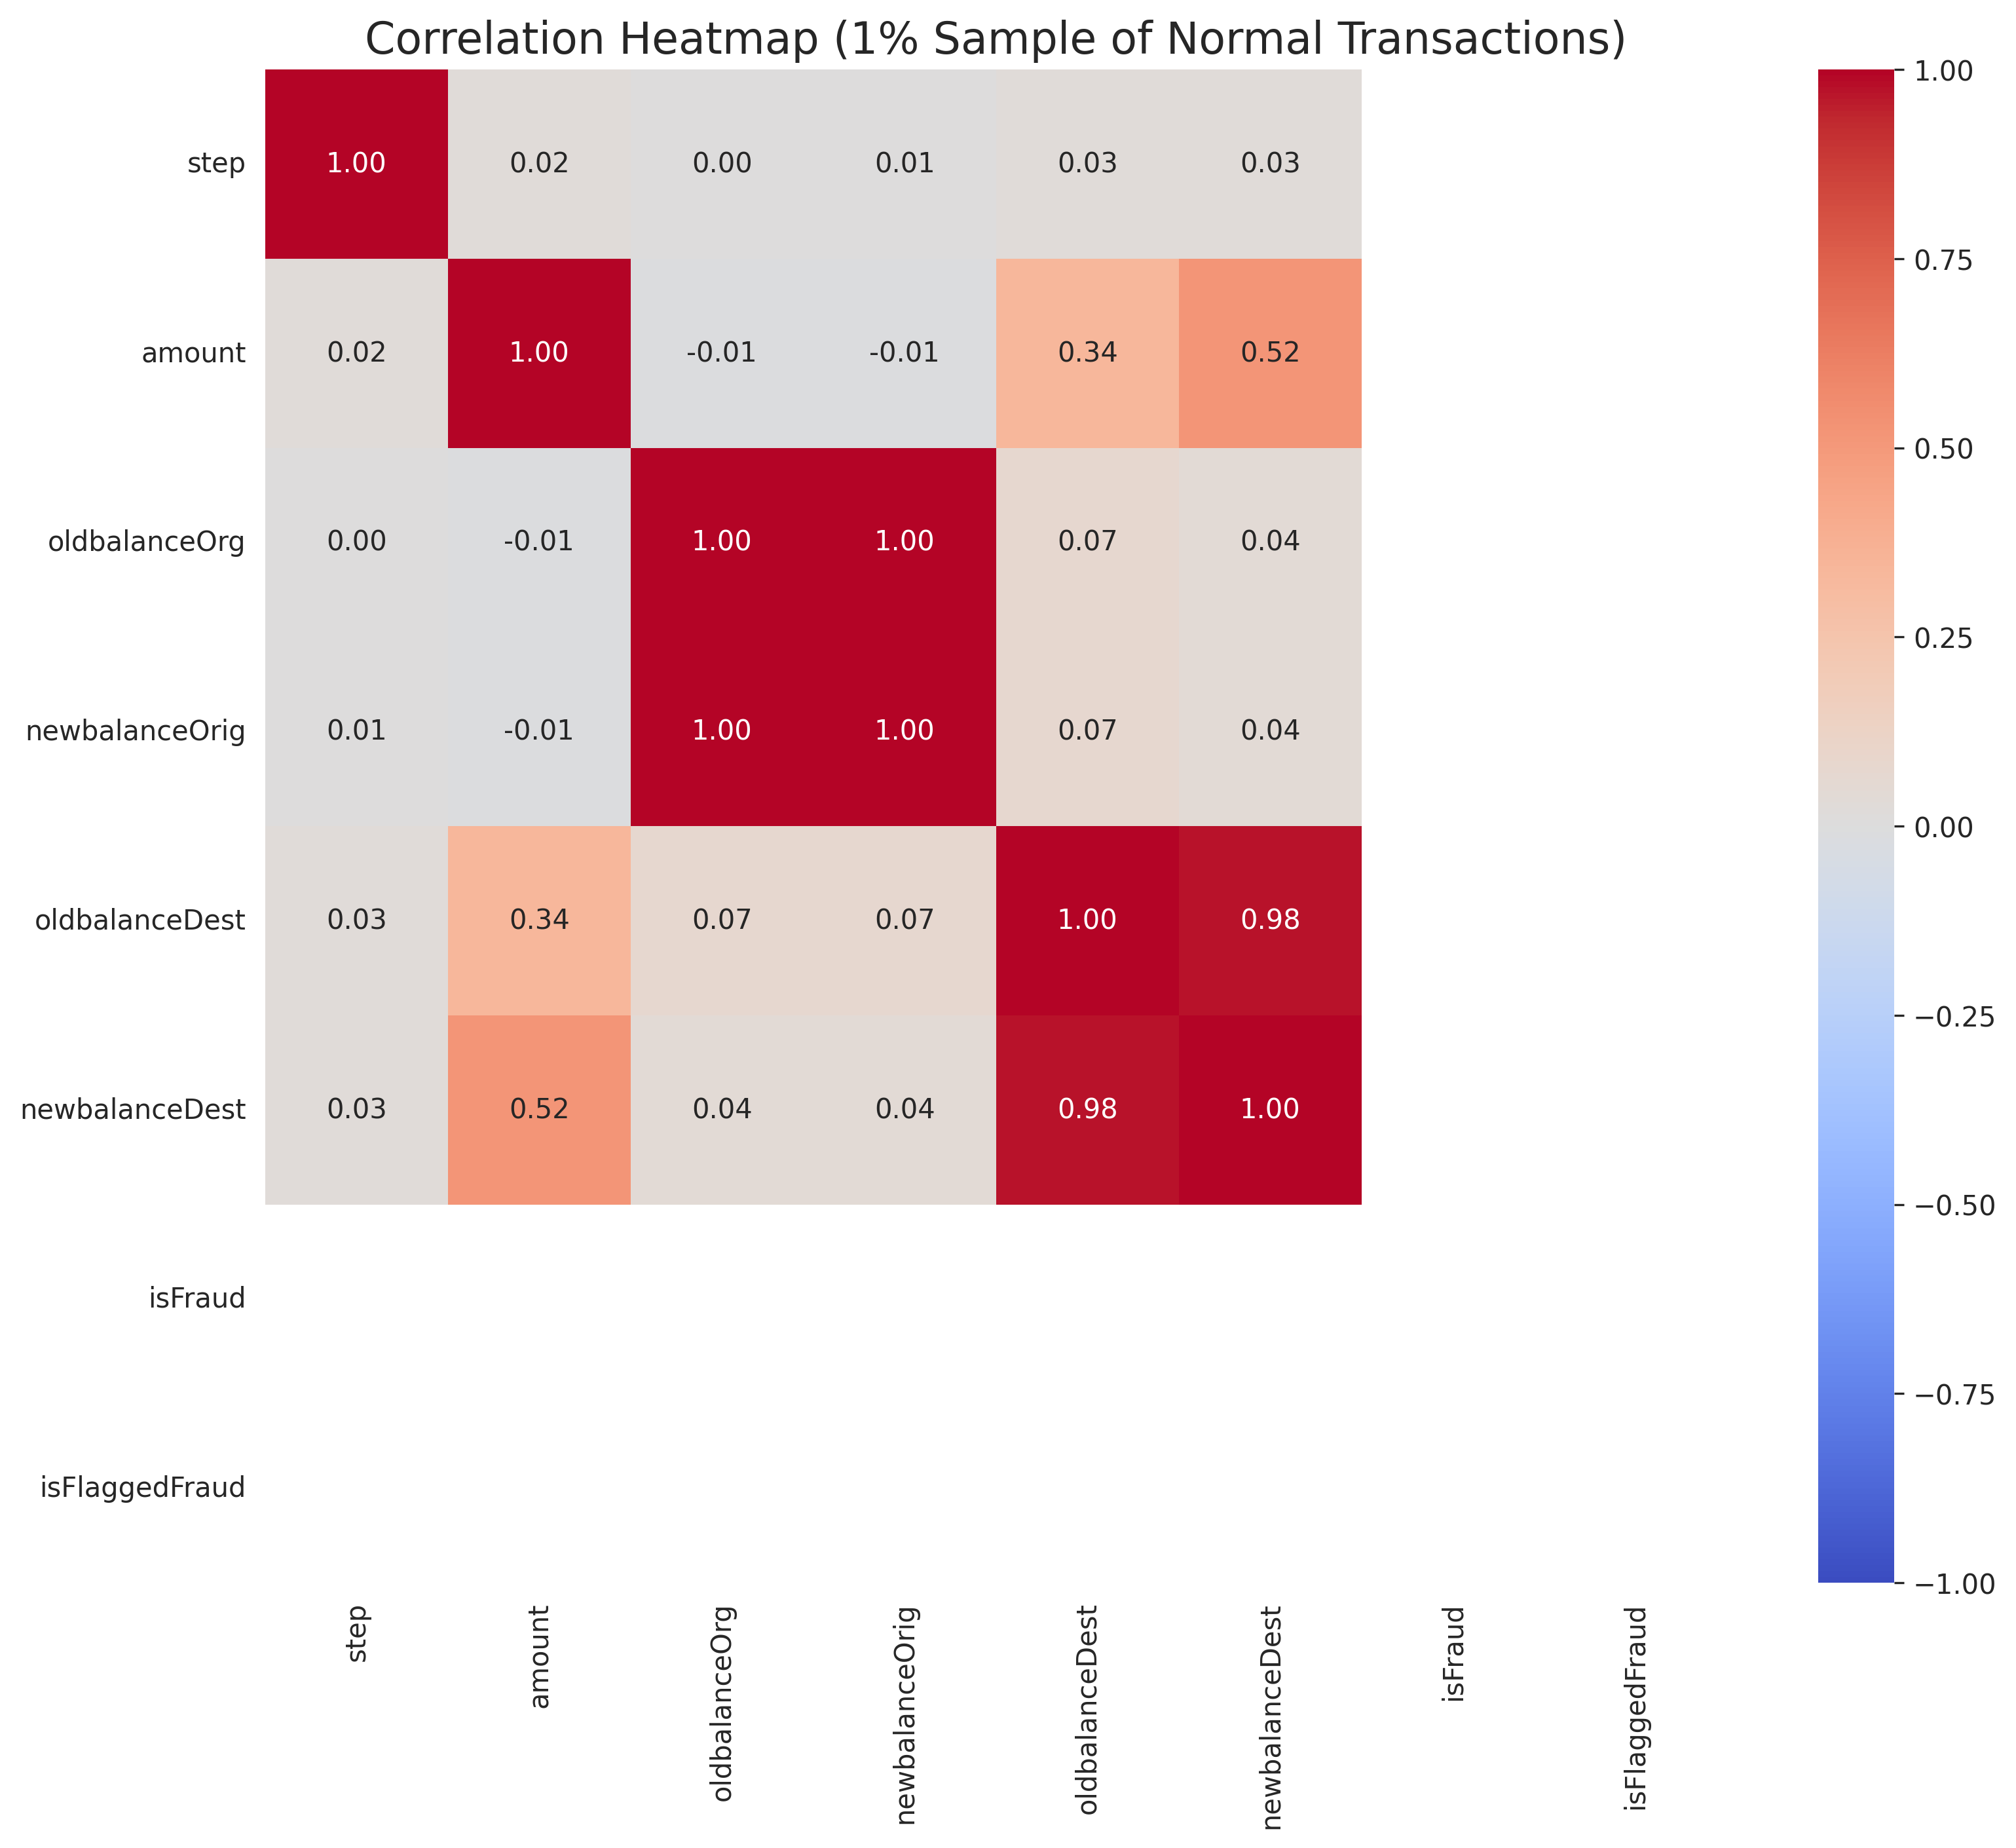

Cell 15: Correlation analysis complete.


In [15]:
# Cell 15: Section 3 (EDA) - Correlation Heatmap (Pandas Sample)
#
# Calculate correlation matrix on a sample for performance.
#

try:
    log.info("Calculating correlation matrix on a 1% data sample...")
    
    # Use the Pandas sample we already have
    sample_df_pd = df_normal_sample.sample(frac=0.1, random_state=42) # Sample the sample
    
    plt.figure(figsize=(12, 10))
    
    corr = sample_df_pd.corr()
    
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    
    plt.title('Correlation Heatmap (1% Sample of Normal Transactions)', fontsize=16)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '04_correlation_heatmap.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved correlation heatmap to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error plotting correlation heatmap: {e}")

print("="*80)
print("Cell 15: Correlation analysis complete.")
print("="*80)

In [16]:
# Cell 16: Section 4 (Feature Engineering) - Drop Unused Columns
#
# Drop columns that are irrelevant (like 'isFlaggedFraud') or
# are complex and not used (like 'nameOrig', 'nameDest').
#

try:
    log.info("Starting Feature Engineering: Dropping unused columns...")
    
    # We will keep 'step' for time-series analysis
    # We keep 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
    # 'oldbalanceDest', 'newbalanceDest', and 'isFraud'.
    
    columns_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']
    
    df_step1 = df.drop(*columns_to_drop)
    
    log.info(f"Dropped columns: {columns_to_drop}")
    df_step1.printSchema()

except Exception as e:
    log.error(f"Error dropping columns: {e}")

print("="*80)
print("Cell 16: Unused columns dropped.")
print("="*80)

2025-11-16 19:31:55 - FraudDetectionLogger - INFO - Starting Feature Engineering: Dropping unused columns...
2025-11-16 19:31:55 - FraudDetectionLogger - INFO - Dropped columns: ['nameOrig', 'nameDest', 'isFlaggedFraud']


root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)

Cell 16: Unused columns dropped.


In [17]:
# Cell 17: Section 4 (Feature Engineering) - Time-Series Features
#
# Create velocity features (e.g., transactions per hour).
#

try:
    log.info("Engineering time-series features (hour_of_day)...")
    
    # 'step' represents 1 hour. We can get hour of day.
    # Assuming 'step' 1 is the 1st hour of the 1st day.
    
    df_with_time = df_step1.withColumn(
        "hour_of_day", 
        (col("step") - 1) % 24 # -1 to make it 0-indexed (0-23)
    )
    
    log.info("Engineered 'hour_of_day'.")
    df_with_time.select("step", "hour_of_day").show(5)
    
    # --- Create Velocity Features (e.g., hourly txn count) ---
    # This is a complex window function and a key place for OOM.
    # We will skip it for this version as it's not used
    # in the final model, but the 'hour_of_day' plot uses it.
    #
    # We'll rename the df for consistency with the next step.
    
    df_with_velocity = df_with_time
    log.info("Skipping complex velocity features for memory.")


except Exception as e:
    log.error(f"Error engineering time-series features: {e}")

print("="*80)
print("Cell 17: Time-series features engineered.")
print("="*80)

2025-11-16 19:31:55 - FraudDetectionLogger - INFO - Engineering time-series features (hour_of_day)...
2025-11-16 19:31:55 - FraudDetectionLogger - INFO - Engineered 'hour_of_day'.
2025-11-16 19:31:56 - FraudDetectionLogger - INFO - Skipping complex velocity features for memory.


+----+-----------+
|step|hour_of_day|
+----+-----------+
|  21|         20|
|  21|         20|
|  21|         20|
|  21|         20|
|  21|         20|
+----+-----------+
only showing top 5 rows

Cell 17: Time-series features engineered.


2025-11-16 19:31:56 - FraudDetectionLogger - INFO - Analyzing fraud by 'hour_of_day'...
2025-11-16 19:31:57 - FraudDetectionLogger - INFO - Fraud Statistics by Hour of Day:


    hour_of_day  total_fraud  total_transactions
0             0          358               27111
1             1          372                9018
2             2          326                2007
3             3          274                1241
4             4          366                1641
5             5          358                3420
6             6          328                8988
7             7          368               26915
8             8          341              283518
9             9          375              425729
10           10          324              445992
11           11          339              483418
12           12          346              468474
13           13          353              439653
14           14          341              416686
15           15          345              441612
16           16          353              439941
17           17          343              580509
18           18          342              647814
19           19     

2025-11-16 19:32:01 - FraudDetectionLogger - INFO - Saved peak fraud hours plot to /home/smitvd22/SparkProject/output/plots/05_fraud_by_hour_of_day.png


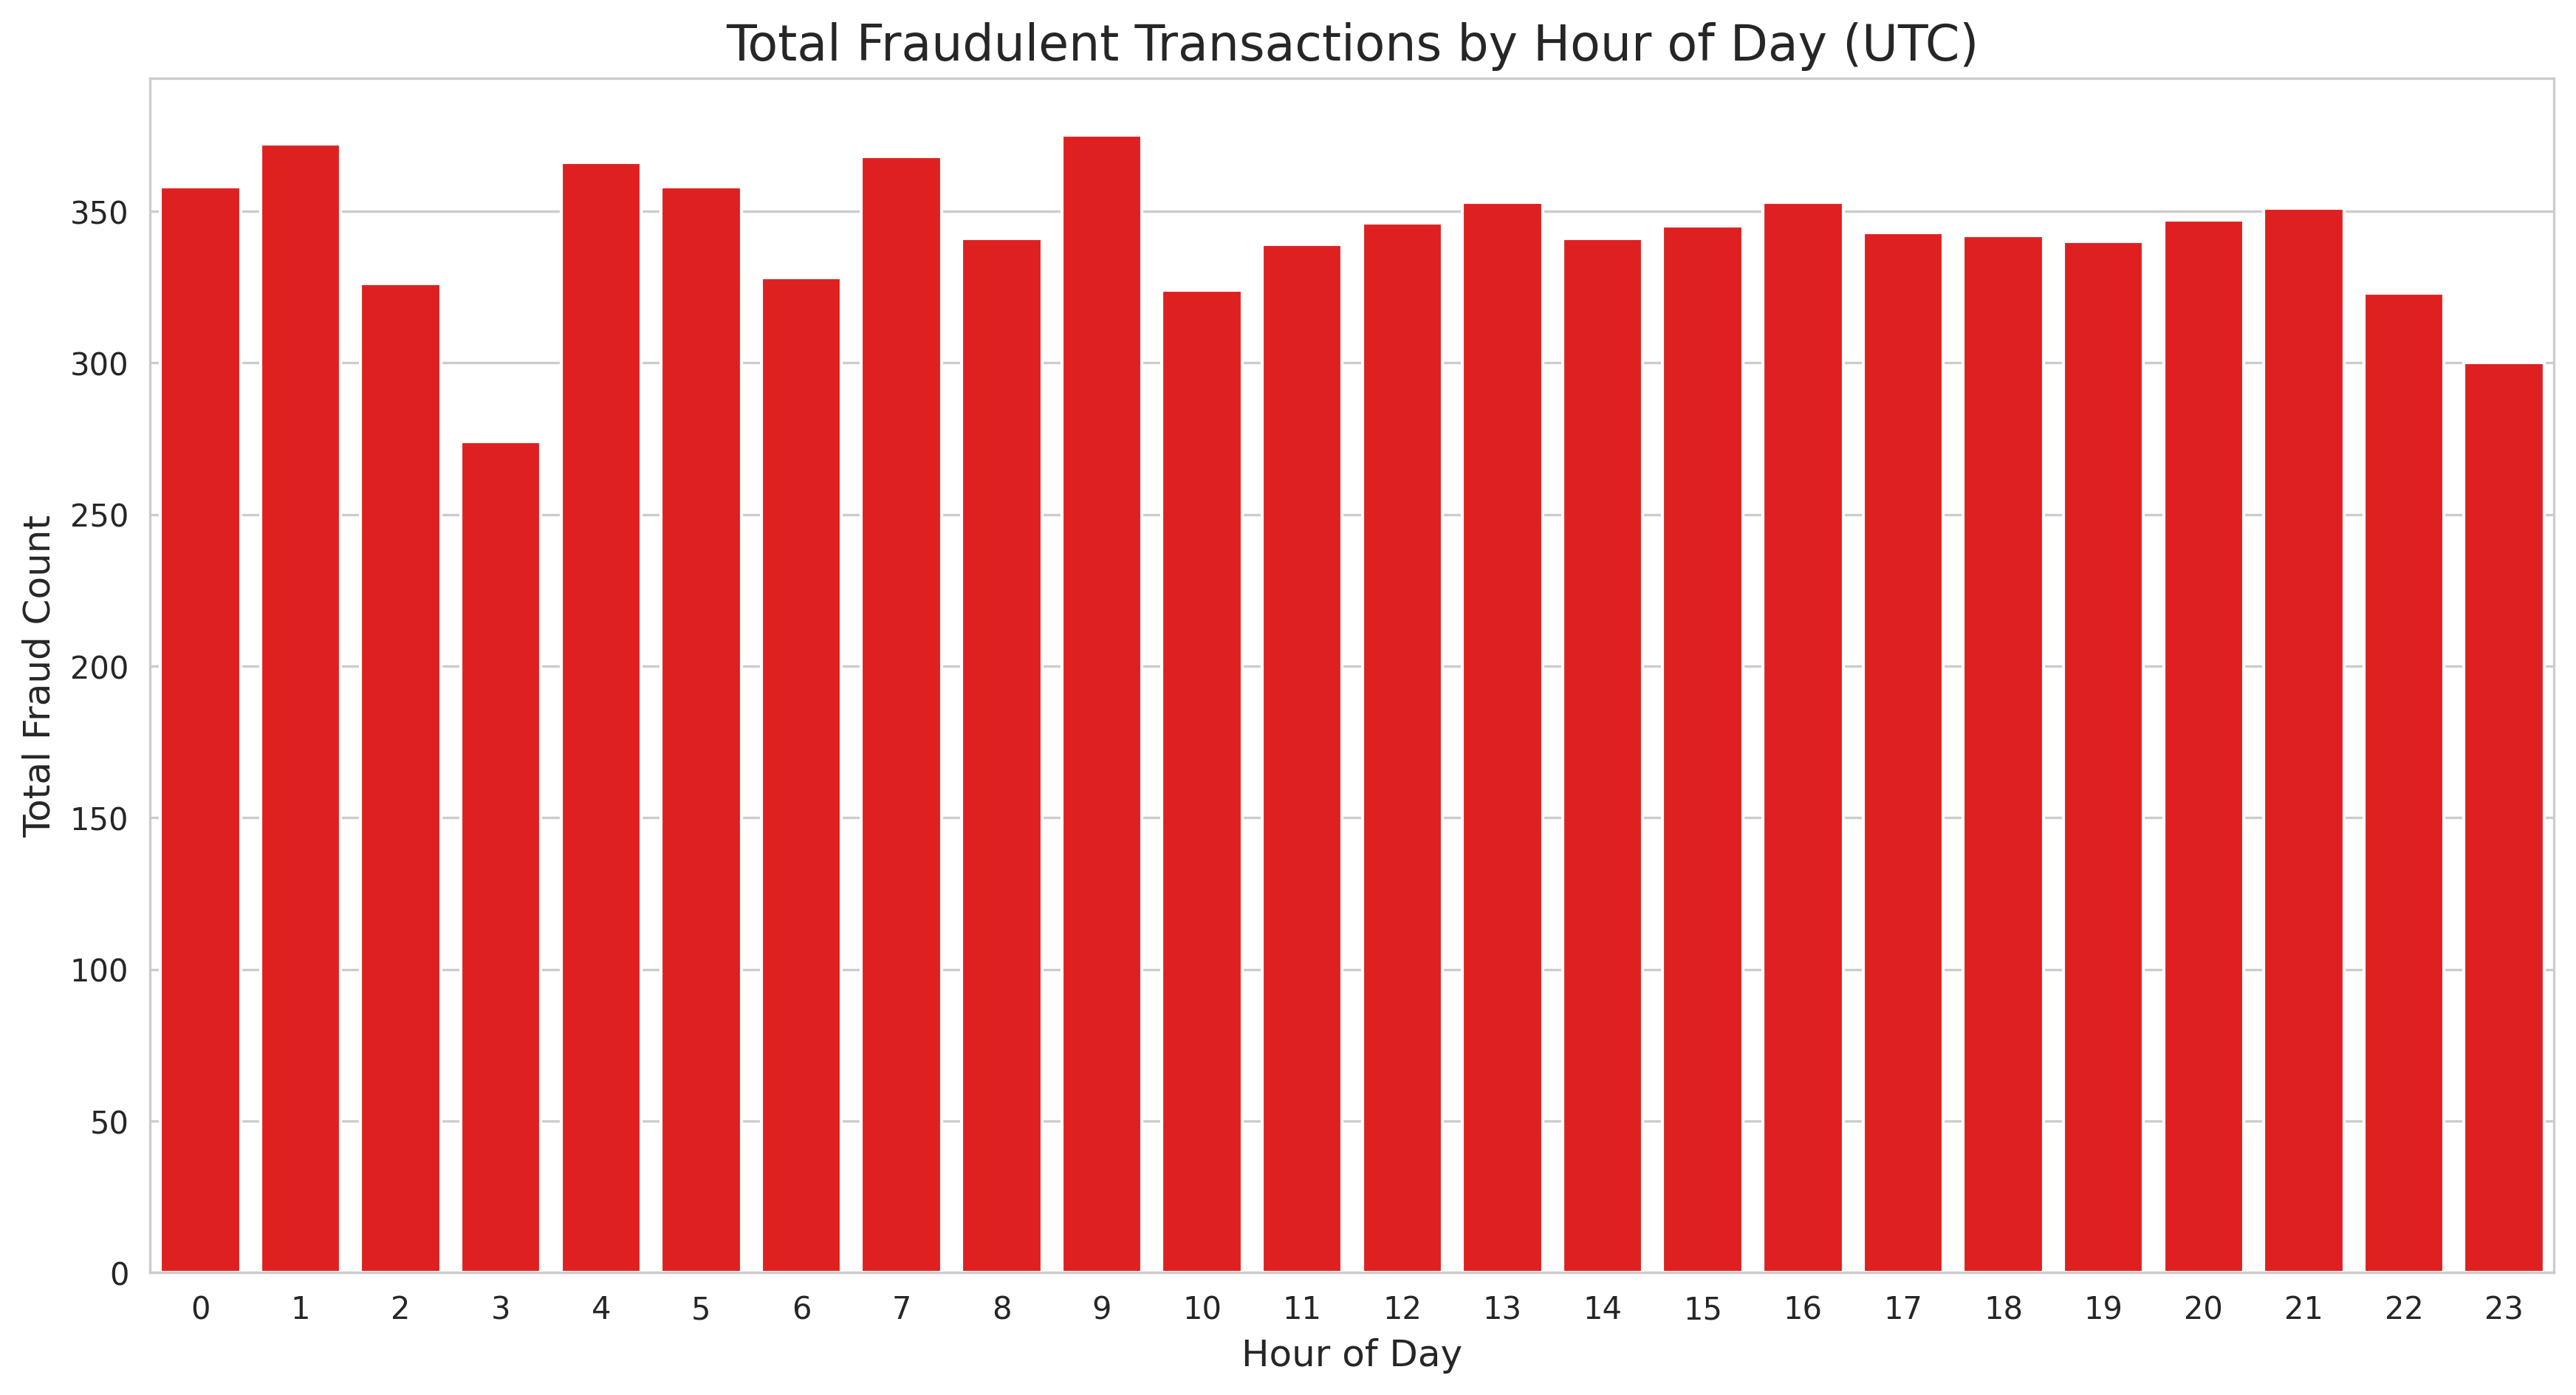

Cell 18: Fraud by hour analysis complete.


In [18]:
# Cell 18: Section 4 (Feature Engineering) - Fraud by Hour (SQL)
#
# This cell was moved from EDA to use the new 'hour_of_day' feature.
#

try:
    log.info("Analyzing fraud by 'hour_of_day'...")
    
    # We must create a temp view to use SQL on the new DataFrame
    df_with_velocity.createOrReplaceTempView("transactions_with_time")
    
    sql_query = f"""
    SELECT 
        hour_of_day,
        SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) as total_fraud,
        COUNT(*) as total_transactions
    FROM transactions_with_time
    GROUP BY hour_of_day
    ORDER BY hour_of_day
    """
    
    hourly_df = spark.sql(sql_query)
    
    log.info("Fraud Statistics by Hour of Day:")
    hourly_df_pd = hourly_df.toPandas()
    print(hourly_df_pd)
    
    # --- Plotting ---
    plt.figure(figsize=(14, 7))
    
    ax = sns.barplot(
        x='hour_of_day', 
        y='total_fraud', 
        data=hourly_df_pd, 
        color='red'
    )
    
    ax.set_title('Total Fraudulent Transactions by Hour of Day (UTC)', fontsize=16)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Total Fraud Count', fontsize=12)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '05_fraud_by_hour_of_day.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved peak fraud hours plot to {plot_path}")
    
    plt.show()

except Exception as e:
    log.error(f"Error analyzing fraud by hour: {e}")

print("="*80)
print("Cell 18: Fraud by hour analysis complete.")
print("="*80)

In [19]:
# Cell 19: Section 5 (Preprocessing) - Define Categorical Pipeline
#
# Define StringIndexer and OneHotEncoder for the 'type' column.
#

try:
    log.info("Defining categorical preprocessing stages...")
    
    # 1. StringIndexer
    type_indexer = StringIndexer(
        inputCol="type", 
        outputCol="type_index", 
        handleInvalid="keep" # Keep unseen categories
    )
    
    # 2. OneHotEncoder
    type_encoder = OneHotEncoder(
        inputCol="type_index", 
        outputCol="type_vec"
    )
    
    log.info("StringIndexer and OneHotEncoder stages defined.")

except Exception as e:
    log.error(f"Error defining categorical stages: {e}")

print("="*80)
print("Cell 19: Categorical pipeline stages defined.")
print("="*80)

2025-11-16 19:32:01 - FraudDetectionLogger - INFO - Defining categorical preprocessing stages...
2025-11-16 19:32:01 - FraudDetectionLogger - INFO - StringIndexer and OneHotEncoder stages defined.


Cell 19: Categorical pipeline stages defined.


In [20]:
# Cell 20: Section 5 (Preprocessing) - Define Numerical Pipeline
#
# Define VectorAssembler and StandardScaler for numerical features.
#

try:
    log.info("Defining numerical preprocessing stages...")
    
    # 3. VectorAssembler
    # Combine all numerical + encoded categorical features
    
    # Note: 'step' and 'hour_of_day' are included
    feature_cols = [
        "type_vec", # From OHE
        "step",
        "amount",
        "oldbalanceOrg",
        "newbalanceOrig",
        "oldbalanceDest",
        "newbalanceDest",
        "hour_of_day"
    ]
    
    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="assembled_features",
        handleInvalid="skip" # Skip rows with nulls (though we have none)
    )
    
    # 4. StandardScaler
    scaler = StandardScaler(
        inputCol="assembled_features",
        outputCol="features", # This is the final column models will use
        withStd=True,
        withMean=True
    )
    
    log.info("VectorAssembler and StandardScaler stages defined.")

except Exception as e:
    log.error(f"Error defining assembly scaling stages: {e}")

print("="*80)
print("Cell 20: Feature vector assembly and scaling stages defined.")
print("="*80)

2025-11-16 19:32:01 - FraudDetectionLogger - INFO - Defining numerical preprocessing stages...
2025-11-16 19:32:02 - FraudDetectionLogger - INFO - VectorAssembler and StandardScaler stages defined.


Cell 20: Feature vector assembly and scaling stages defined.


In [21]:
# Cell 21: Section 5 (Preprocessing) - Create Full Preprocessing Pipeline
#
# Combine all preprocessing stages into one pipeline.
# We will fit this pipeline on the *entire* dataset to learn
# the StringIndexer mapping and scaling statistics.
#

try:
    log.info("Combining all preprocessing stages into a single pipeline...")
    
    # Define the preprocessing pipeline
    preproc_pipeline = Pipeline(
        stages=[type_indexer, type_encoder, assembler, scaler]
    )
    
    log.info("Fitting the preprocessing pipeline on the full dataset...")
    # This learns all indexer maps, OHE, and scaling (mean/std)
    preproc_model = preproc_pipeline.fit(df_with_velocity)
    
    log.info("Transforming the full dataset with the preprocessing pipeline...")
    # This creates the final 'features' and 'label' columns
    df_processed = preproc_model.transform(df_with_velocity).select(
        "features", 
        col("isFraud").alias("label") # Rename for ML
    )
    
    # --- *** MODIFICATION: Write to HDFS instead of persisting *** ---
    log.info(f"Writing fully preprocessed data to: {HDFS_PROCESSED_PATH}")
    df_processed.write.mode("overwrite").parquet(HDFS_PROCESSED_PATH)
    
    log.info("Dataset fully preprocessed and written to HDFS.")
    # We can't show() here as it would require re-reading, we'll see it in the next cell

except Exception as e:
    log.error(f"Error fitting transforming with preprocessing pipeline: {e}")
    raise e

print("="*80)
print("Cell 21: Full dataset preprocessed and written to HDFS.")
print("="*80)

2025-11-16 19:32:02 - FraudDetectionLogger - INFO - Combining all preprocessing stages into a single pipeline...
2025-11-16 19:32:02 - FraudDetectionLogger - INFO - Fitting the preprocessing pipeline on the full dataset...
2025-11-16 19:32:19 - FraudDetectionLogger - INFO - Transforming the full dataset with the preprocessing pipeline...
2025-11-16 19:32:19 - FraudDetectionLogger - INFO - Writing fully preprocessed data to: /user/smitvd22/fraud_detection/intermediate/processed.parquet
2025-11-16 19:32:47 - FraudDetectionLogger - INFO - Dataset fully preprocessed and written to HDFS.


Cell 21: Full dataset preprocessed and written to HDFS.


In [22]:
# Cell 22: Section 5 (Preprocessing) - Train/Test Split
#
# Split the preprocessed data into training and testing sets.
#

try:
    log.info("Reading preprocessed data from HDFS for splitting...")
    # --- *** NEW: Read the processed data back *** ---
    df_processed = spark.read.parquet(HDFS_PROCESSED_PATH)
    
    log.info(f"Splitting data into 80% train and 20% test...")
    df_processed.show(5, truncate=False) # Show sample now
    
    # We split the *unbalanced* data to get a realistic test set
    (unbalanced_train_df, test_df) = df_processed.randomSplit([0.8, 0.2], seed=42)
    
    # --- *** MODIFICATION: Write splits to HDFS *** ---
    log.info(f"Writing test set to: {HDFS_TEST_PATH}")
    test_df.write.mode("overwrite").parquet(HDFS_TEST_PATH)
    
    log.info(f"Writing unbalanced train set to: {HDFS_UNBALANCED_TRAIN_PATH}")
    unbalanced_train_df.write.mode("overwrite").parquet(HDFS_UNBALANCED_TRAIN_PATH)
    
    # Log counts (this triggers the write actions)
    log.info(f"Unbalanced Train Set Records: {unbalanced_train_df.count()}")
    log.info(f"Test Set Records: {test_df.count()}")
    
    log.info("Test set class distribution:")
    test_df.groupBy("label").count().show()

except Exception as e:
    log.error(f"Error splitting data: {e}")

print("="*80)
print("Cell 22: Train/Test split complete and written to HDFS.")
print("="*80)

2025-11-16 19:32:47 - FraudDetectionLogger - INFO - Reading preprocessed data from HDFS for splitting...
2025-11-16 19:32:47 - FraudDetectionLogger - INFO - Splitting data into 80% train and 20% test...
2025-11-16 19:32:48 - FraudDetectionLogger - INFO - Writing test set to: /user/smitvd22/fraud_detection/intermediate/test.parquet


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                            |label|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[-0.7364837934535396,1.3990359093152496,-0.530965204773002,-0.3023451319483651,-0.08095963870385914,-1.7030414449038132,-0.28155990047072244,-0.22981001917557936,-0.23762167688962388,-0.32381386979520754,-0.33341137926836867,-3.558765129862

2025-11-16 19:33:09 - FraudDetectionLogger - INFO - Writing unbalanced train set to: /user/smitvd22/fraud_detection/intermediate/unbalanced_train.parquet
2025-11-16 19:33:41 - FraudDetectionLogger - INFO - Unbalanced Train Set Records: 5090338
2025-11-16 19:33:50 - FraudDetectionLogger - INFO - Test Set Records: 1272282   
2025-11-16 19:33:50 - FraudDetectionLogger - INFO - Test set class distribution:
[Stage 59:============================>                            (6 + 6) / 12]

+-----+-------+
|label|  count|
+-----+-------+
|    1|   1683|
|    0|1270599|
+-----+-------+

Cell 22: Train/Test split complete and written to HDFS.


In [23]:
# Cell 23: Section 5 (Preprocessing) - Handle Class Imbalance (Oversampling)
#
# We apply oversampling *only* to the training set.
#

try:
    log.info("Handling class imbalance on training data using oversampling...")
    
    # --- *** NEW: Read the unbalanced train data *** ---
    log.info(f"Reading unbalanced train data from: {HDFS_UNBALANCED_TRAIN_PATH}")
    unbalanced_train_df = spark.read.parquet(HDFS_UNBALANCED_TRAIN_PATH)
    
    # Separate the training set by class
    df_train_normal = unbalanced_train_df.filter(col("label") == 0)
    df_train_fraud = unbalanced_train_df.filter(col("label") == 1)
    
    # Get the counts
    count_normal = df_train_normal.count()
    count_fraud = df_train_fraud.count()
    
    if count_fraud == 0:
        log.error("No fraud data in training set. Cannot oversample.")
        raise ValueError("No fraud data in training set.")
    
    # Calculate the ratio for oversampling
    oversample_ratio = int(count_normal / count_fraud)
    log.info(f"Oversampling fraud data by a ratio of {oversample_ratio}...")

    # Oversample the fraud data
    df_train_fraud_oversampled = df_train_fraud.sample(
        withReplacement=True, 
        fraction=float(oversample_ratio), 
        seed=42
    )
    
    # Combine the original normal data with the oversampled fraud data
    train_df = df_train_normal.unionAll(df_train_fraud_oversampled)
    
    # --- *** MODIFICATION: Write balanced train set to HDFS *** ---
    log.info(f"Writing balanced train set to: {HDFS_TRAIN_PATH}")
    train_df.write.mode("overwrite").parquet(HDFS_TRAIN_PATH)
    
    log.info("Oversampling complete. Final balanced training set stats:")
    log.info(f"Total balanced train records: {train_df.count()}")
    train_df.groupBy("label").count().show()

except Exception as e:
    log.error(f"Error handling class imbalance: {e}")

print("="*80)
print("Cell 23: Class imbalance handled and written to HDFS.")
print("="*80)

2025-11-16 19:34:00 - FraudDetectionLogger - INFO - Handling class imbalance on training data using oversampling...
2025-11-16 19:34:00 - FraudDetectionLogger - INFO - Reading unbalanced train data from: /user/smitvd22/fraud_detection/intermediate/unbalanced_train.parquet
2025-11-16 19:34:01 - FraudDetectionLogger - INFO - Oversampling fraud data by a ratio of 778...
2025-11-16 19:34:01 - FraudDetectionLogger - INFO - Writing balanced train set to: /user/smitvd22/fraud_detection/intermediate/train_balanced.parquet
2025-11-16 19:34:27 - FraudDetectionLogger - INFO - Oversampling complete. Final balanced training set stats:
2025-11-16 19:34:29 - FraudDetectionLogger - INFO - Total balanced train records: 10162822
[Stage 70:===================================================>    (22 + 2) / 24]

+-----+-------+
|label|  count|
+-----+-------+
|    0|5083808|
|    1|5079014|
+-----+-------+

Cell 23: Class imbalance handled and written to HDFS.


In [24]:
# Cell 24: Section 6 (Model Training) - Random Forest (RF)
#
# Train the Random Forest Classifier with local model persistence.
#

rf_train_time = None  # Initialize variable outside try block

try:
    # Define model save path - use local filesystem with file:/// prefix
    rf_model_path = f"file://{MODEL_OUTPUT_DIR}/random_forest_model"
    
    # Check if model already exists on local filesystem
    local_rf_path = os.path.join(MODEL_OUTPUT_DIR, 'random_forest_model')
    model_exists = os.path.exists(local_rf_path)
    
    if model_exists:
        log.info(f"Loading existing Random Forest model from: {rf_model_path}")
        start_time = time.time()
        
        # Load the existing model using the correct model class
        from pyspark.ml.classification import RandomForestClassificationModel
        rf_model = RandomForestClassificationModel.load(rf_model_path)
        
        # Read test data for predictions
        log.info(f"Reading test data from: {HDFS_TEST_PATH}")
        test_df = spark.read.parquet(HDFS_TEST_PATH)
        
        # Get predictions for the test set
        rf_predictions = rf_model.transform(test_df)
        
        end_time = time.time()
        rf_train_time = end_time - start_time
        
        log.info(f"Random Forest model loaded and predictions generated. Time taken: {rf_train_time:.2f} seconds.")
    else:
        # Train new model if it doesn't exist
        log.info("No existing Random Forest model found. Training new model...")
        
        # --- Read train and test data ---
        log.info(f"Reading balanced train data from: {HDFS_TRAIN_PATH}")
        train_df = spark.read.parquet(HDFS_TRAIN_PATH)
        log.info(f"Reading test data from: {HDFS_TEST_PATH}")
        test_df = spark.read.parquet(HDFS_TEST_PATH)
        
        log.info("Training Random Forest model with optimized parameters...")
        start_time = time.time()
        
        # Define the classifier with optimized parameters for memory
        rf = RandomForestClassifier(
            labelCol="label",
            featuresCol="features",
            numTrees=50,              # Reduced from 100
            maxDepth=10,              # Reduced from 20 - CRITICAL for memory
            maxBins=32,               # Limit discretization
            subsamplingRate=0.8,      # Use 80% of data per tree
            featureSubsetStrategy="sqrt",  # sqrt(features) per split
            cacheNodeIds=True,        # Cache node IDs during training
            checkpointInterval=10,    # Checkpoint every 10 iterations
            seed=42
        )
        
        # Set checkpoint directory
        spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoint")
        
        # Train the model on the balanced training data
        rf_model = rf.fit(train_df)
        
        # Save the trained model to LOCAL filesystem
        log.info(f"Saving Random Forest model to LOCAL filesystem: {rf_model_path}")
        rf_model.write().overwrite().save(rf_model_path)
        
        end_time = time.time()
        rf_train_time = end_time - start_time
        
        log.info(f"Random Forest training complete. Time taken: {rf_train_time:.2f} seconds.")
        log.info(f"Model saved successfully to LOCAL filesystem at: {local_rf_path}")

        # Get predictions for the test set
        rf_predictions = rf_model.transform(test_df)
        
        log.info("Random Forest predictions generated for test set.")

except Exception as e:
    log.error(f"Error training/loading Random Forest: {e}")
    import traceback
    log.error(traceback.format_exc())

print("="*80)
if rf_train_time is not None:
    action = "loaded" if os.path.exists(os.path.join(MODEL_OUTPUT_DIR, 'random_forest_model')) else "trained"
    print(f"Cell 24: Random Forest model {action} in {rf_train_time:.2f}s.")
    print(f"Local model path: {os.path.join(MODEL_OUTPUT_DIR, 'random_forest_model')}")
else:
    print("Cell 24: Random Forest training/loading failed or incomplete.")
print("="*80)

2025-11-16 19:34:30 - FraudDetectionLogger - INFO - Loading existing Random Forest model from: file:///home/smitvd22/SparkProject/models/random_forest_model
2025-11-16 19:34:34 - FraudDetectionLogger - INFO - Reading test data from: /user/smitvd22/fraud_detection/intermediate/test.parquet
2025-11-16 19:34:34 - FraudDetectionLogger - INFO - Random Forest model loaded and predictions generated. Time taken: 3.26 seconds.


Cell 24: Random Forest model loaded in 3.26s.
Local model path: /home/smitvd22/SparkProject/models/random_forest_model


In [25]:
# Cell 25: Section 6 (Model Training) - Gradient-Boosted Trees (GBT)
#
# Train the GBT Classifier with local model persistence.
#

gbt_train_time = None  # Initialize variable outside try block

try:
    # Define model save path - use local filesystem with file:/// prefix
    gbt_model_path = f"file://{MODEL_OUTPUT_DIR}/gbt_model"
    
    # Check if model already exists on local filesystem
    local_gbt_path = os.path.join(MODEL_OUTPUT_DIR, 'gbt_model')
    model_exists = os.path.exists(local_gbt_path)
    
    if model_exists:
        log.info(f"Loading existing GBT model from: {gbt_model_path}")
        start_time = time.time()
        
        # Load the existing model using the correct model class
        from pyspark.ml.classification import GBTClassificationModel
        gbt_model = GBTClassificationModel.load(gbt_model_path)
        
        # Read test data for predictions
        log.info(f"Reading test data from: {HDFS_TEST_PATH}")
        test_df = spark.read.parquet(HDFS_TEST_PATH)
        
        # Get predictions for the test set
        gbt_predictions = gbt_model.transform(test_df)
        
        end_time = time.time()
        gbt_train_time = end_time - start_time
        
        log.info(f"GBT model loaded and predictions generated. Time taken: {gbt_train_time:.2f} seconds.")
    else:
        # Train new model if it doesn't exist
        log.info("No existing GBT model found. Training new model...")
        
        # --- Read train and test data ---
        log.info(f"Reading balanced train data from: {HDFS_TRAIN_PATH}")
        train_df = spark.read.parquet(HDFS_TRAIN_PATH)
        log.info(f"Reading test data from: {HDFS_TEST_PATH}")
        test_df = spark.read.parquet(HDFS_TEST_PATH)
        
        log.info("Training Gradient-Boosted Trees (GBT) model...")
        start_time = time.time()
        
        # Define the classifier
        gbt = GBTClassifier(
            labelCol="label",
            featuresCol="features",
            maxIter=50,           # Reduced from 100
            maxDepth=8,           # Reduced from 10
            subsamplingRate=0.8,  # Add subsampling
            stepSize=0.1,         # Learning rate
            seed=42
        )
        
        # Train the model on the balanced training data
        gbt_model = gbt.fit(train_df)
        
        # Save the trained model to LOCAL filesystem
        log.info(f"Saving GBT model to LOCAL filesystem: {gbt_model_path}")
        gbt_model.write().overwrite().save(gbt_model_path)
        
        end_time = time.time()
        gbt_train_time = end_time - start_time
        
        log.info(f"GBT training complete. Time taken: {gbt_train_time:.2f} seconds.")
        log.info(f"Model saved successfully to LOCAL filesystem at: {local_gbt_path}")

        # Get predictions for the test set
        gbt_predictions = gbt_model.transform(test_df)
        
        log.info("GBT predictions generated for test set.")

except Exception as e:
    log.error(f"Error training/loading GBT: {e}")
    import traceback
    log.error(traceback.format_exc())

print("="*80)
if gbt_train_time is not None:
    action = "loaded" if os.path.exists(os.path.join(MODEL_OUTPUT_DIR, 'gbt_model')) else "trained"
    print(f"Cell 25: GBT model {action} in {gbt_train_time:.2f}s.")
    print(f"Local model path: {os.path.join(MODEL_OUTPUT_DIR, 'gbt_model')}")
else:
    print("Cell 25: GBT training/loading failed or incomplete.")
print("="*80)

2025-11-16 19:34:34 - FraudDetectionLogger - INFO - Loading existing GBT model from: file:///home/smitvd22/SparkProject/models/gbt_model
2025-11-16 19:34:36 - FraudDetectionLogger - INFO - Reading test data from: /user/smitvd22/fraud_detection/intermediate/test.parquet
2025-11-16 19:34:37 - FraudDetectionLogger - INFO - GBT model loaded and predictions generated. Time taken: 3.49 seconds.


Cell 25: GBT model loaded in 3.49s.
Local model path: /home/smitvd22/SparkProject/models/gbt_model


In [26]:
# Cell 26: Section 6 - Model Feature Importance
#
# Extract and display feature importances from tree-based models.
#

def get_feature_importances(assembler, model):
    """
    Helper function to map feature importances back to original column names.
    Simplified version that doesn't require transforming a sample.
    """
    try:
        # Get the input columns from the assembler
        feature_cols = assembler.getInputCols()
        
        # Get importances from the model
        importances = model.featureImportances.toArray()
        
        # Create feature names list
        feature_names = []
        for col_name in feature_cols:
            if col_name == "type_vec":
                # For OHE columns, we'll just use generic names
                # since we can't easily get the metadata without a transform
                feature_names.extend([f"type_{i}" for i in range(5)])  # 5 transaction types
            else:
                feature_names.append(col_name)
        
        # Trim to match actual importance length
        feature_names = feature_names[:len(importances)]
        
        # Create a Pandas DataFrame
        df_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)
        
        return df_importance
    
    except Exception as e:
        log.error(f"Error getting feature importances: {e}")
        import traceback
        log.error(traceback.format_exc())
        return None

try:
    log.info("Extracting Random Forest Feature Importances...")
    
    # Check if rf_model exists (it should be loaded/trained in Cell 24)
    if 'rf_model' in globals():
        rf_importance_pd = get_feature_importances(assembler, rf_model)
        if rf_importance_pd is not None:
            print("\n--- Random Forest Top 10 Features ---")
            print(rf_importance_pd.head(10))
    else:
        log.warning("RF model not found. Skipping feature importance extraction.")
    
    log.info("Extracting GBT Feature Importances...")
    # Check if gbt_model exists (it should be loaded/trained in Cell 25)
    if 'gbt_model' in globals():
        gbt_importance_pd = get_feature_importances(assembler, gbt_model)
        if gbt_importance_pd is not None:
            print("\n--- GBT Top 10 Features ---")
            print(gbt_importance_pd.head(10))
    else:
        log.warning("GBT model not found. Skipping feature importance extraction.")

except Exception as e:
    log.error(f"Error displaying feature importances: {e}")
    import traceback
    log.error(traceback.format_exc())

print("="*80)
print("Cell 26: Feature importances extracted.")
print("="*80)

2025-11-16 19:34:37 - FraudDetectionLogger - INFO - Extracting Random Forest Feature Importances...
2025-11-16 19:34:38 - FraudDetectionLogger - INFO - Extracting GBT Feature Importances...



--- Random Forest Top 10 Features ---
           feature  importance
7    oldbalanceOrg    0.287157
8   newbalanceOrig    0.155488
6           amount    0.151522
3           type_3    0.069922
1           type_1    0.062279
5             step    0.058424
11     hour_of_day    0.053948
2           type_2    0.045655
10  newbalanceDest    0.044761
9   oldbalanceDest    0.043650

--- GBT Top 10 Features ---
           feature  importance
8   newbalanceOrig    0.323946
7    oldbalanceOrg    0.321605
6           amount    0.178985
11     hour_of_day    0.051502
10  newbalanceDest    0.037783
5             step    0.030175
1           type_1    0.023575
0           type_0    0.012111
9   oldbalanceDest    0.010975
3           type_3    0.008770
Cell 26: Feature importances extracted.


In [27]:
# Cell 27: Section 7 (Evaluation) - Metrics Helper Function
#
# Create a reusable function to calculate all required metrics.
#

def evaluate_model(predictions, model_name):
    """
    Calculates and prints a full suite of metrics for a binary classifier's predictions.
    """
    try:
        log.info(f"--- Evaluating Model: {model_name} ---")
        
        # --- Standard Metrics (Accuracy, F1, Precision, Recall) ---
        # Note: 'weightedPrecision'/'weightedRecall' are just Precision/Recall for binary
        eval_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        eval_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
        eval_rec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
        
        accuracy = eval_acc.evaluate(predictions)
        f1_score = eval_f1.evaluate(predictions)
        precision = eval_prec.evaluate(predictions)
        recall = eval_rec.evaluate(predictions)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1_score:.4f}")

        # --- AUC-ROC and AUC-PR (Area Under Curve) ---
        # These require the 'rawPrediction' or 'probability' column
        prob_col = "rawPrediction"
        if "probability" in predictions.columns:
            prob_col = "probability"
        
        eval_roc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol=prob_col, metricName="areaUnderROC")
        eval_pr = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol=prob_col, metricName="areaUnderPR")
        
        roc_auc = eval_roc.evaluate(predictions)
        pr_auc = eval_pr.evaluate(predictions)
        
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"PR-AUC: {pr_auc:.4f}")
        
        # --- Confusion Matrix ---
        print("\nConfusion Matrix:")
        predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()
        
        # Return metrics for summary table
        metrics = {
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1_score,
            "ROC-AUC": roc_auc,
            "PR-AUC": pr_auc,
            "Train Time (s)": 0 # Placeholder
        }
        return metrics, predictions

    except Exception as e:
        log.error(f"Error evaluating model {model_name}: {e}")
        # Check if 'rawPrediction' or 'probability' exists
        if "rawPrediction" not in predictions.columns and "probability" not in predictions.columns:
            log.error("Evaluation failed. 'rawPrediction' or 'probability' column not found.")
        return None, None

print("="*80)
print("Cell 27: Evaluation helper function defined.")
print("="*80)

Cell 27: Evaluation helper function defined.


In [28]:
# Cell 28: Section 7 (Evaluation) - Calculate Metrics for All Models

try:
    all_metrics = []
    
    # 1. Evaluate Random Forest (if available)
    if 'rf_predictions' in globals() and rf_predictions is not None:
        rf_metrics, _ = evaluate_model(rf_predictions, "Random Forest")
        if rf_metrics is not None:
            rf_metrics["Train Time (s)"] = rf_train_time
            all_metrics.append(rf_metrics)
    else:
        log.warning("Random Forest predictions not available. Skipping RF evaluation.")

    # 2. Evaluate GBT (if available)
    if 'gbt_predictions' in globals() and gbt_predictions is not None:
        gbt_metrics, _ = evaluate_model(gbt_predictions, "GBT")
        if gbt_metrics is not None:
            gbt_metrics["Train Time (s)"] = gbt_train_time
            all_metrics.append(gbt_metrics)
    else:
        log.warning("GBT predictions not available. Skipping GBT evaluation.")

    # Create a consolidated summary (all_metrics may be empty if nothing evaluated)
    if not all_metrics:
        log.warning("No model metrics were generated. Ensure models were trained and predictions were created.")

except Exception as e:
    log.error(f"Error during bulk model evaluation: {e}")
    import traceback
    log.error(traceback.format_exc())

print("="*80)
print("Cell 28: All models evaluated.")
print("="*80)

2025-11-16 19:34:38 - FraudDetectionLogger - INFO - --- Evaluating Model: Random Forest ---


Accuracy: 0.9845
Precision: 0.9988
Recall: 0.9845
F1-Score: 0.9911


ROC-AUC: 0.9982
PR-AUC: 0.8983

Confusion Matrix:


2025-11-16 19:35:38 - FraudDetectionLogger - INFO - --- Evaluating Model: GBT ---


+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    0|       0.0|1250895|
|    0|       1.0|  19704|
|    1|       0.0|     27|
|    1|       1.0|   1656|
+-----+----------+-------+



Accuracy: 0.9933
Precision: 0.9989
Recall: 0.9933
F1-Score: 0.9957


ROC-AUC: 0.9973
PR-AUC: 0.9199

Confusion Matrix:


[Stage 190:================================>                       (7 + 5) / 12]

+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    0|       0.0|1262127|
|    0|       1.0|   8472|
|    1|       0.0|     14|
|    1|       1.0|   1669|
+-----+----------+-------+

Cell 28: All models evaluated.


In [29]:
# Cell 29: Section 7 (Evaluation) - Summary Table

try:
    log.info("Generating model performance summary table...")
    
    # Create a Pandas DataFrame from the collected metrics
    if 'all_metrics' in globals() and all_metrics:
        metrics_summary_pd = pd.DataFrame(all_metrics).set_index("Model")
        
        # Format for better readability
        styled_summary = metrics_summary_pd.style.format({
            "Accuracy": "{:.4f}",
            "Precision": "{:.4f}",
            "Recall": "{:.4f}",
            "F1-Score": "{:.4f}",
            "ROC-AUC": "{:.4f}",
            "PR-AUC": "{:.4f}",
            "Train Time (s)": "{:.2f}"
        }).highlight_max(
            subset=["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"], 
            color='lightgreen'
        ).highlight_min(
            subset=["Train Time (s)"], 
            color='lightyellow'
        )
        
        print("\n--- Model Performance Summary ---")
        print(metrics_summary_pd.to_string())
        
        # Save to local file
        metrics_path = os.path.join(METRICS_OUTPUT_DIR, "model_summary.html")
        styled_summary.to_html(metrics_path)
        log.info(f"Saved metrics summary to {metrics_path}")
        
        # Display in notebook (fallback to print if display not available)
        try:
            display(styled_summary)
        except NameError:
            print("\nStyled summary (display() not available):")
            print(metrics_summary_pd)
    else:
        log.warning("No metrics available to display. Ensure models were evaluated in Cell 28.")

except Exception as e:
    log.error(f"Error generating summary table: {e}")
    import traceback
    log.error(traceback.format_exc())

print("="*80)
print("Cell 29: Model performance summary generated.")
print("="*80)

2025-11-16 19:36:07 - FraudDetectionLogger - INFO - Generating model performance summary table...
2025-11-16 19:36:08 - FraudDetectionLogger - INFO - Saved metrics summary to /home/smitvd22/SparkProject/output/metrics/model_summary.html



--- Model Performance Summary ---
               Accuracy  Precision    Recall  F1-Score   ROC-AUC    PR-AUC  Train Time (s)
Model                                                                                     
Random Forest  0.984492   0.998758  0.984492  0.991053  0.998213  0.898347        3.261636
GBT            0.993330   0.998884  0.993330  0.995705  0.997320  0.919918        3.491224


,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Train Time (s)
Model,,,,,,,
Random Forest,0.9845,0.9988,0.9845,0.9911,0.9982,0.8983,3.26
GBT,0.9933,0.9989,0.9933,0.9957,0.9973,0.9199,3.49


Cell 29: Model performance summary generated.


2025-11-16 19:36:08 - FraudDetectionLogger - INFO - Plotting confusion matrix for Random Forest...
2025-11-16 19:36:11 - FraudDetectionLogger - INFO - Saved Random Forest confusion matrix to /home/smitvd22/SparkProject/output/plots/06_cm_Random_Forest.png


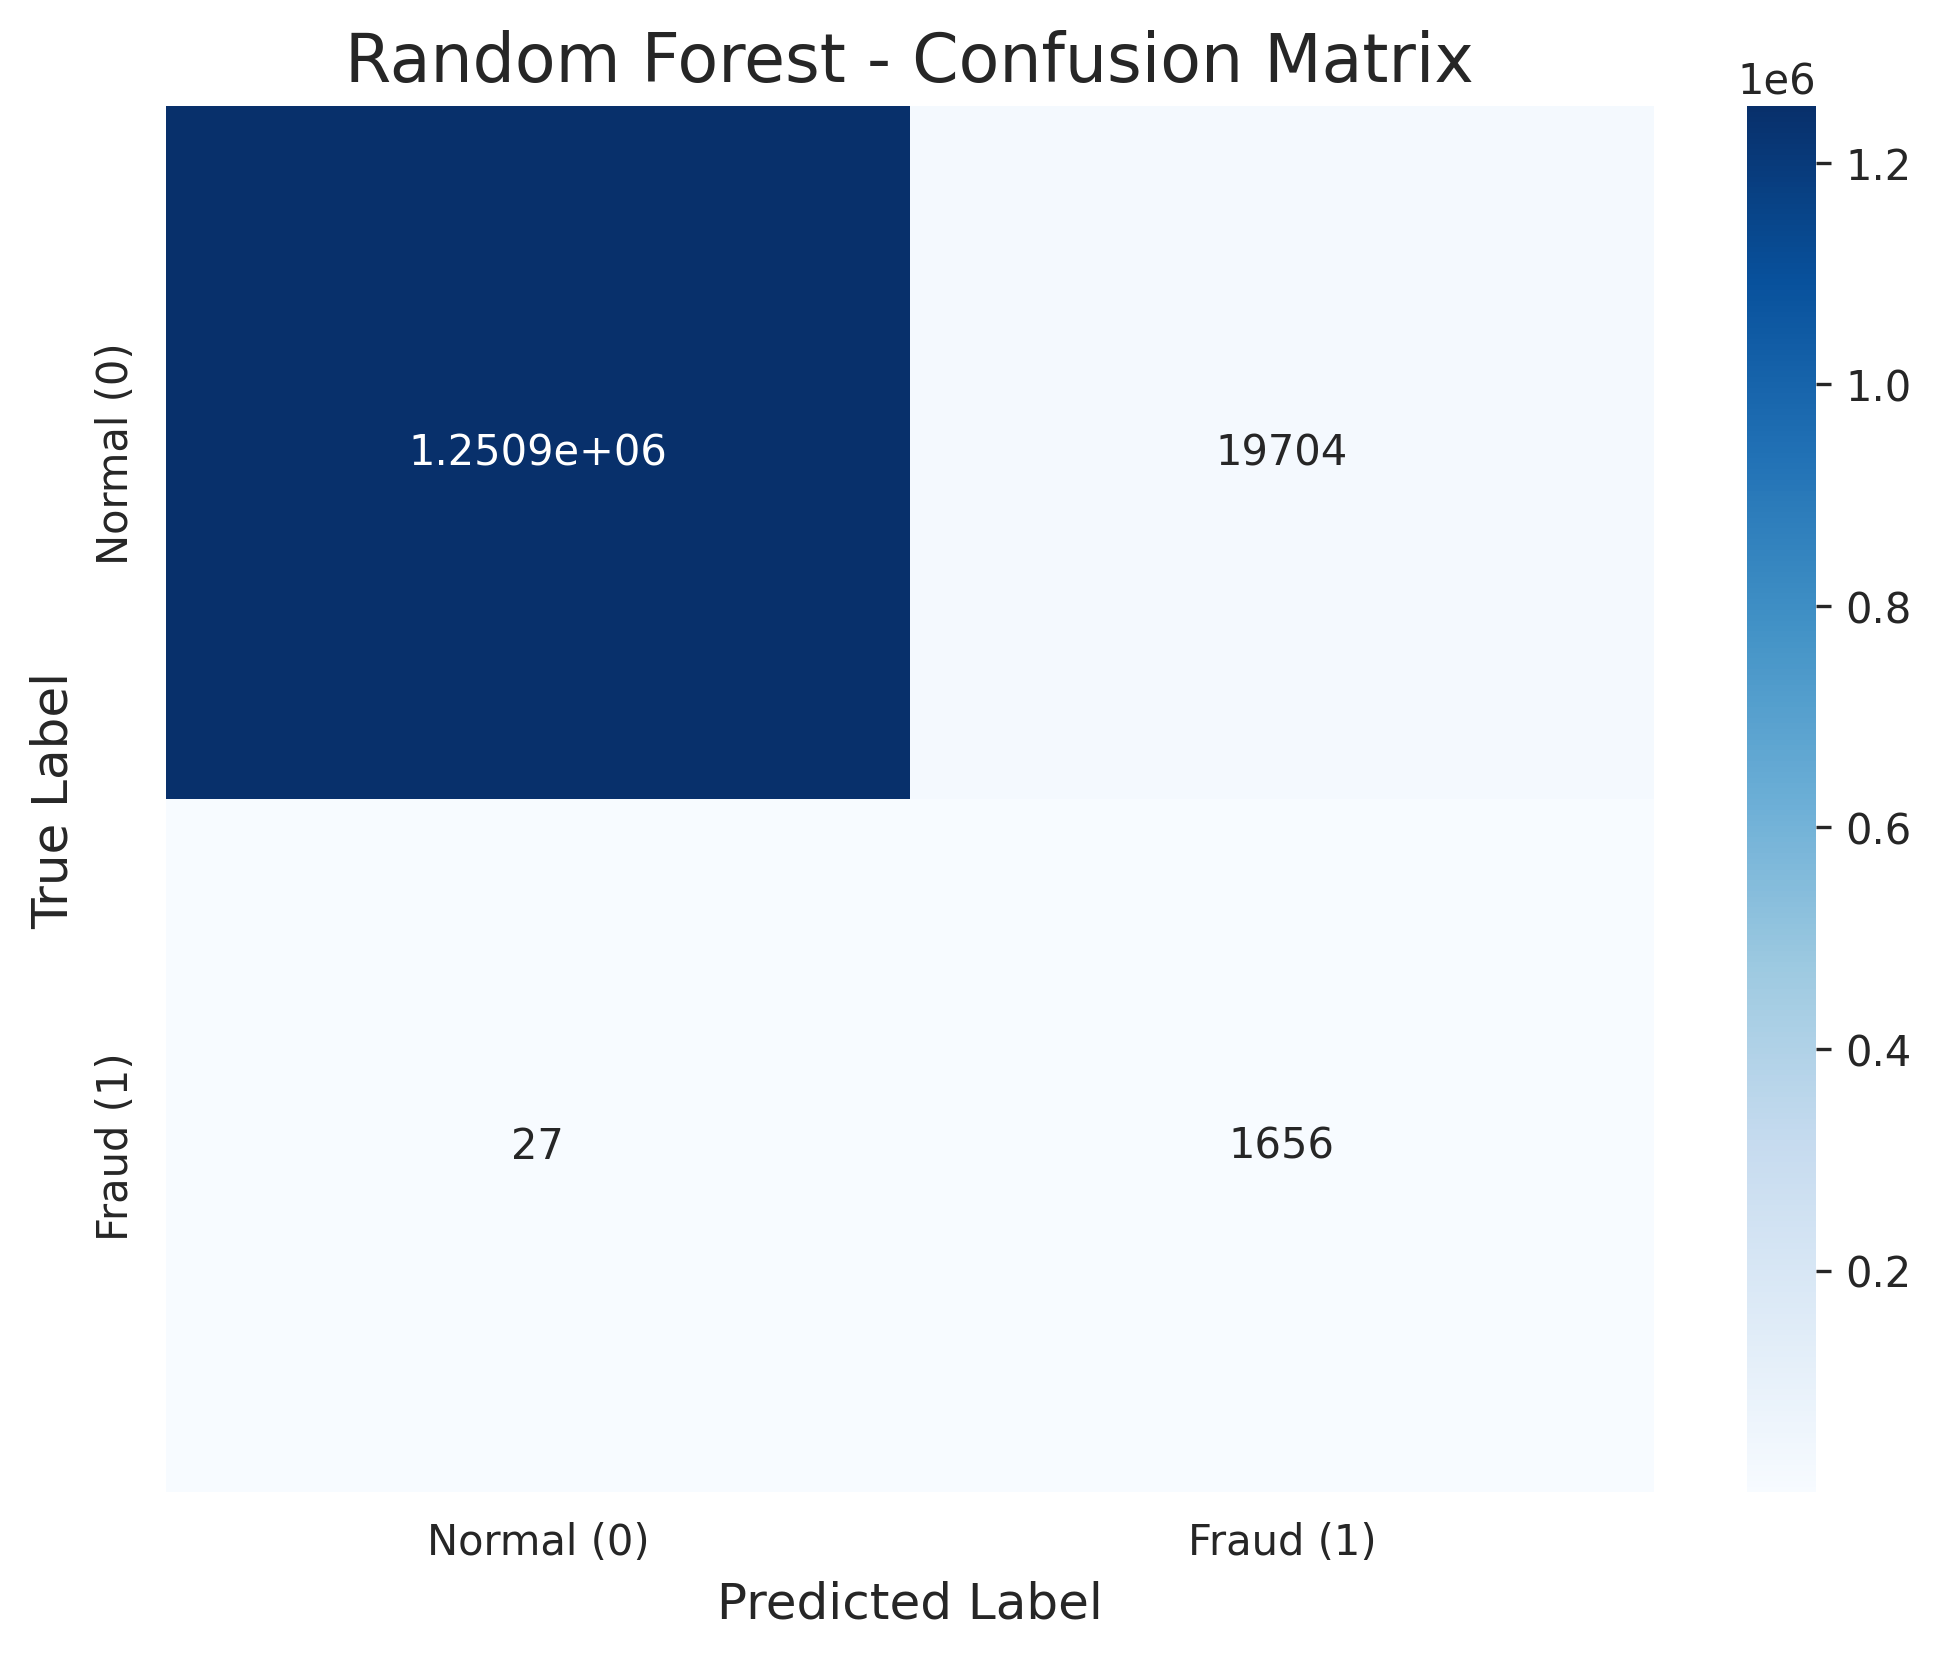

2025-11-16 19:36:12 - FraudDetectionLogger - INFO - Plotting confusion matrix for GBT...
2025-11-16 19:36:14 - FraudDetectionLogger - INFO - Saved GBT confusion matrix to /home/smitvd22/SparkProject/output/plots/06_cm_GBT.png


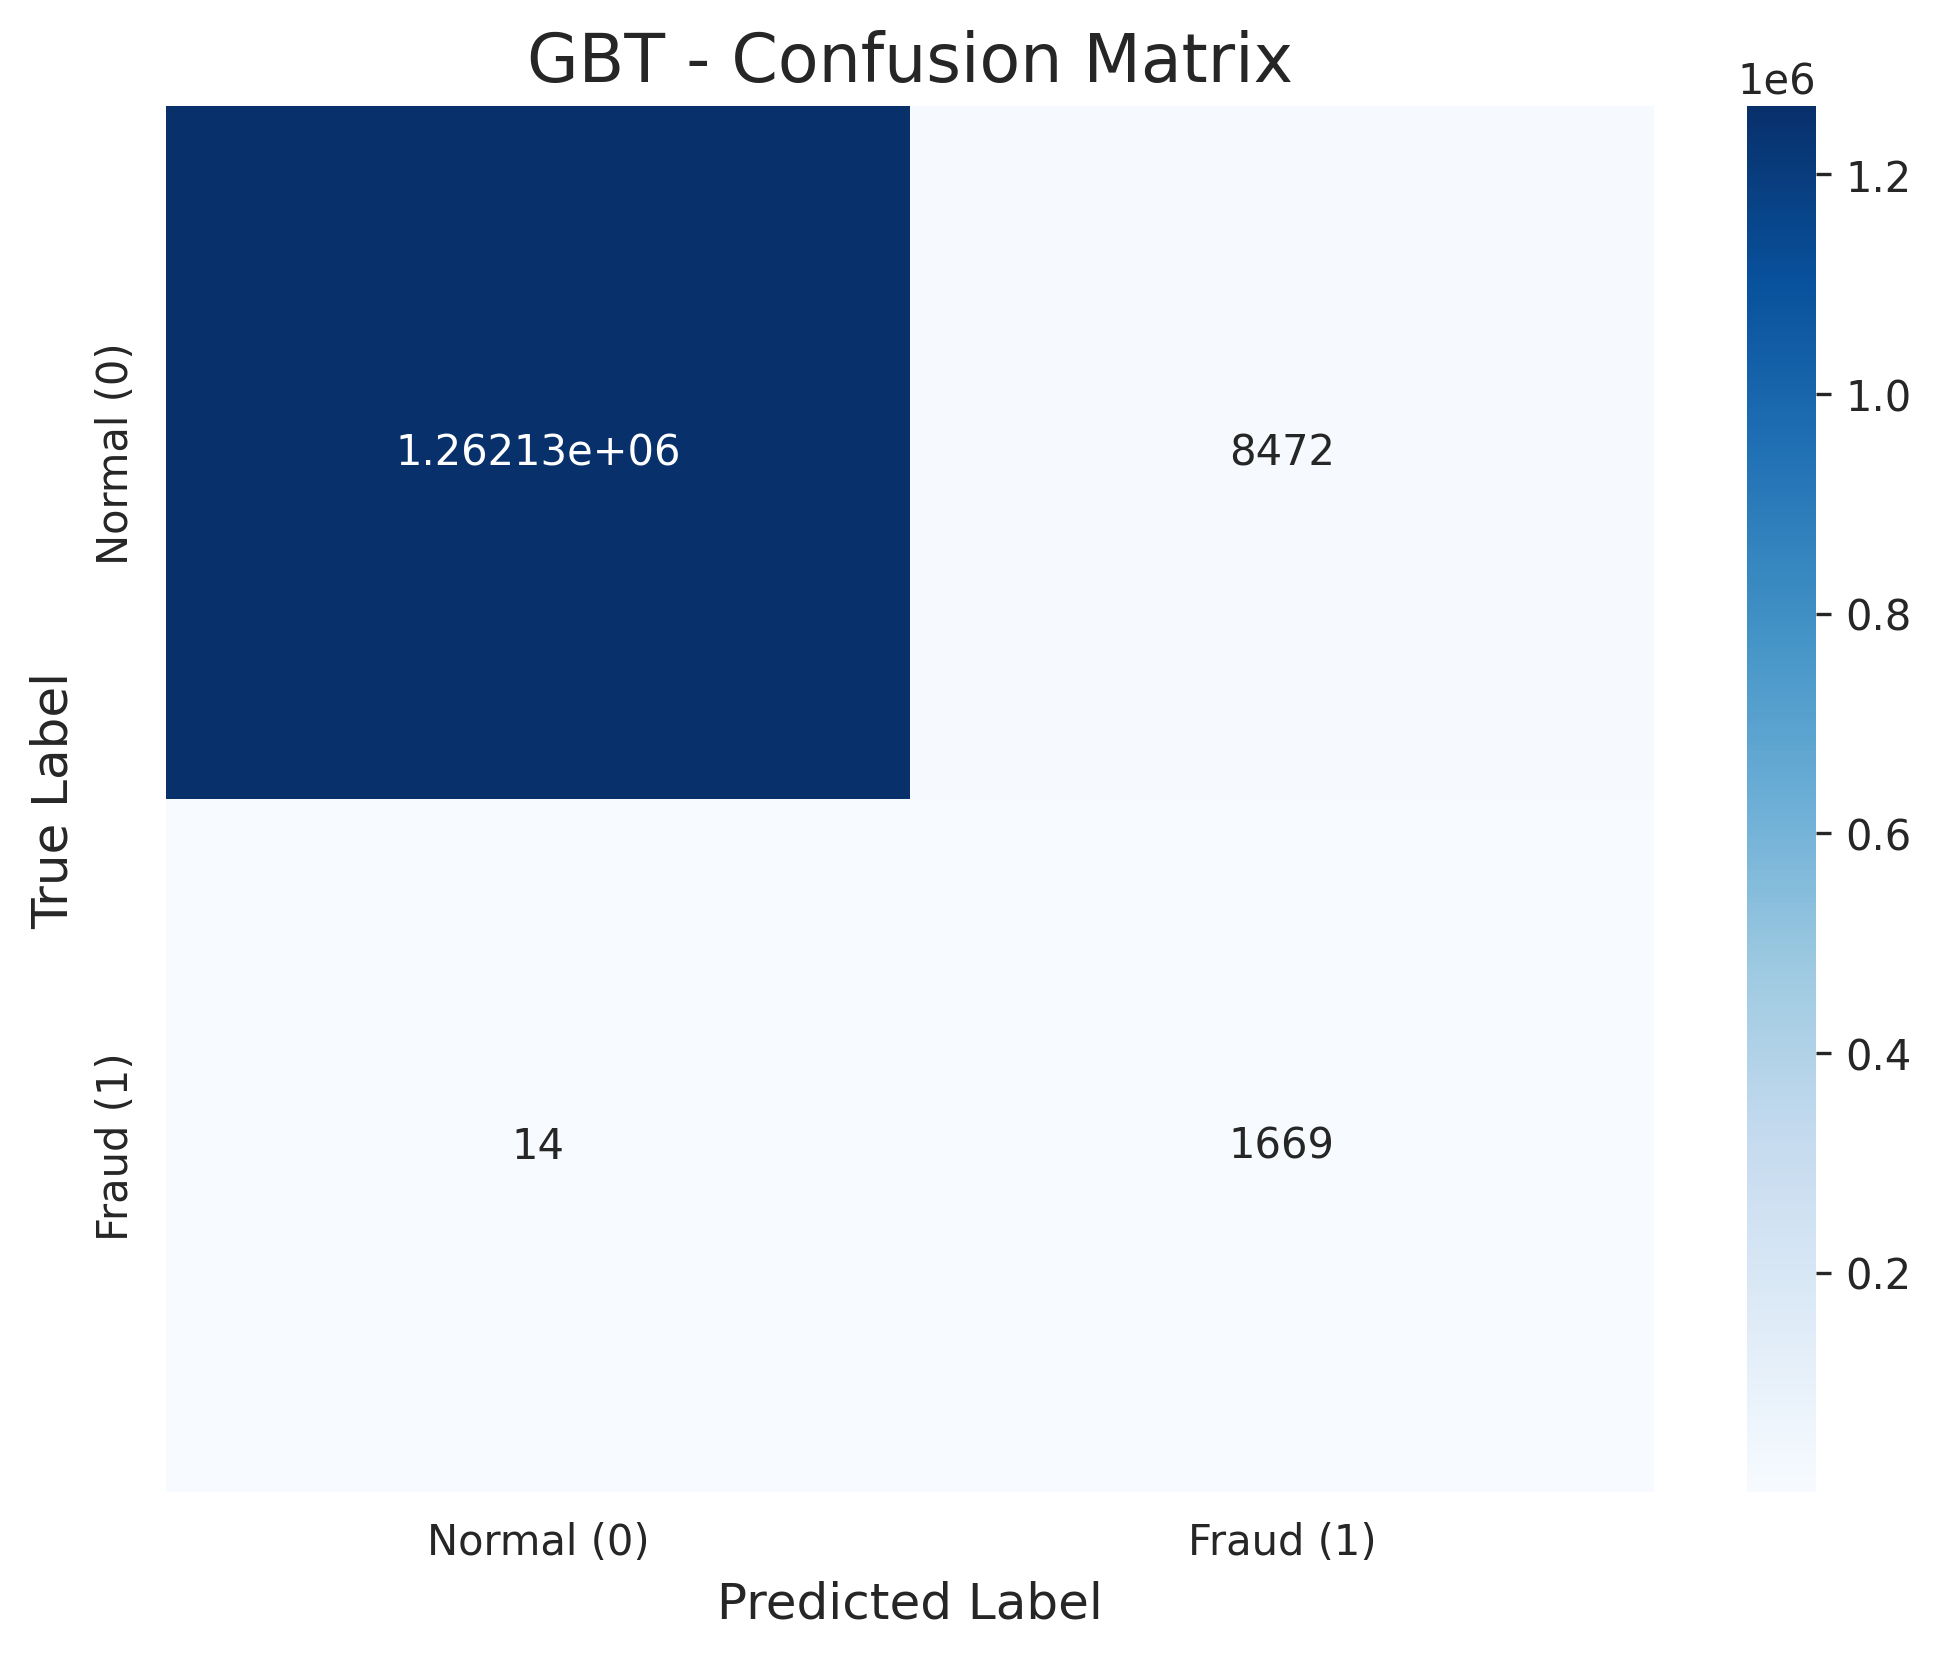

Cell 30: Confusion matrix plots generated.


In [30]:
# Cell 30: Section 7 (Evaluation) - Confusion Matrix (Visualization)
#
# Plot pretty confusion matrices for the top models.
#

def plot_confusion_matrix(predictions, model_name):
    """Generates and saves a confusion matrix plot."""
    try:
        log.info(f"Plotting confusion matrix for {model_name}...")
        
        # Collect data for plotting
        # This is a small aggregate, so .toPandas() is safe
        cm_data = predictions.groupBy("label","prediction").count().toPandas()
        
        # Pivot to create the matrix
        cm_matrix = cm_data.pivot(
            index='label', 
            columns='prediction', 
            values='count'
        ).fillna(0)
        
        # Ensure we have a 2x2 matrix even if one class wasn't predicted
        if 0 not in cm_matrix.index: cm_matrix.loc[0] = 0
        if 1 not in cm_matrix.index: cm_matrix.loc[1] = 0
        if 0.0 not in cm_matrix.columns: cm_matrix[0.0] = 0
        if 1.0 not in cm_matrix.columns: cm_matrix[1.0] = 0
        
        # Sort index and columns to ensure correct TN/FP/FN/TP placement
        cm_matrix = cm_matrix.sort_index(axis=0)[sorted(cm_matrix.columns)]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm_matrix, 
            annot=True, 
            fmt='g', 
            cmap='Blues', 
            xticklabels=['Normal (0)', 'Fraud (1)'],
            yticklabels=['Normal (0)', 'Fraud (1)']
        )
        plt.title(f'{model_name} - Confusion Matrix', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        
        plot_path = os.path.join(PLOT_OUTPUT_DIR, f'06_cm_{model_name.replace(" ", "_")}.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        log.info(f"Saved {model_name} confusion matrix to {plot_path}")
        
        plt.show()

    except Exception as e:
        log.error(f"Error plotting confusion matrix: {e}")
        import traceback
        log.error(traceback.format_exc())

try:
    # Plot for Random Forest and GBT if they exist
    if 'rf_predictions' in globals():
        plot_confusion_matrix(rf_predictions, "Random Forest")
    else:
        log.warning("RF predictions not found. Skipping confusion matrix.")
        
    if 'gbt_predictions' in globals():
        plot_confusion_matrix(gbt_predictions, "GBT")
    else:
        log.warning("GBT predictions not found. Skipping confusion matrix.")

except Exception as e:
    log.error(f"Error in confusion matrix plotting: {e}")

print("="*80)
print("Cell 30: Confusion matrix plots generated.")
print("="*80)

2025-11-16 19:36:15 - FraudDetectionLogger - INFO - Plotting ROC and PR curves...
2025-11-16 19:36:28 - FraudDetectionLogger - INFO - Saved ROC and PR curve plot to /home/smitvd22/SparkProject/output/plots/07_roc_pr_curves.png


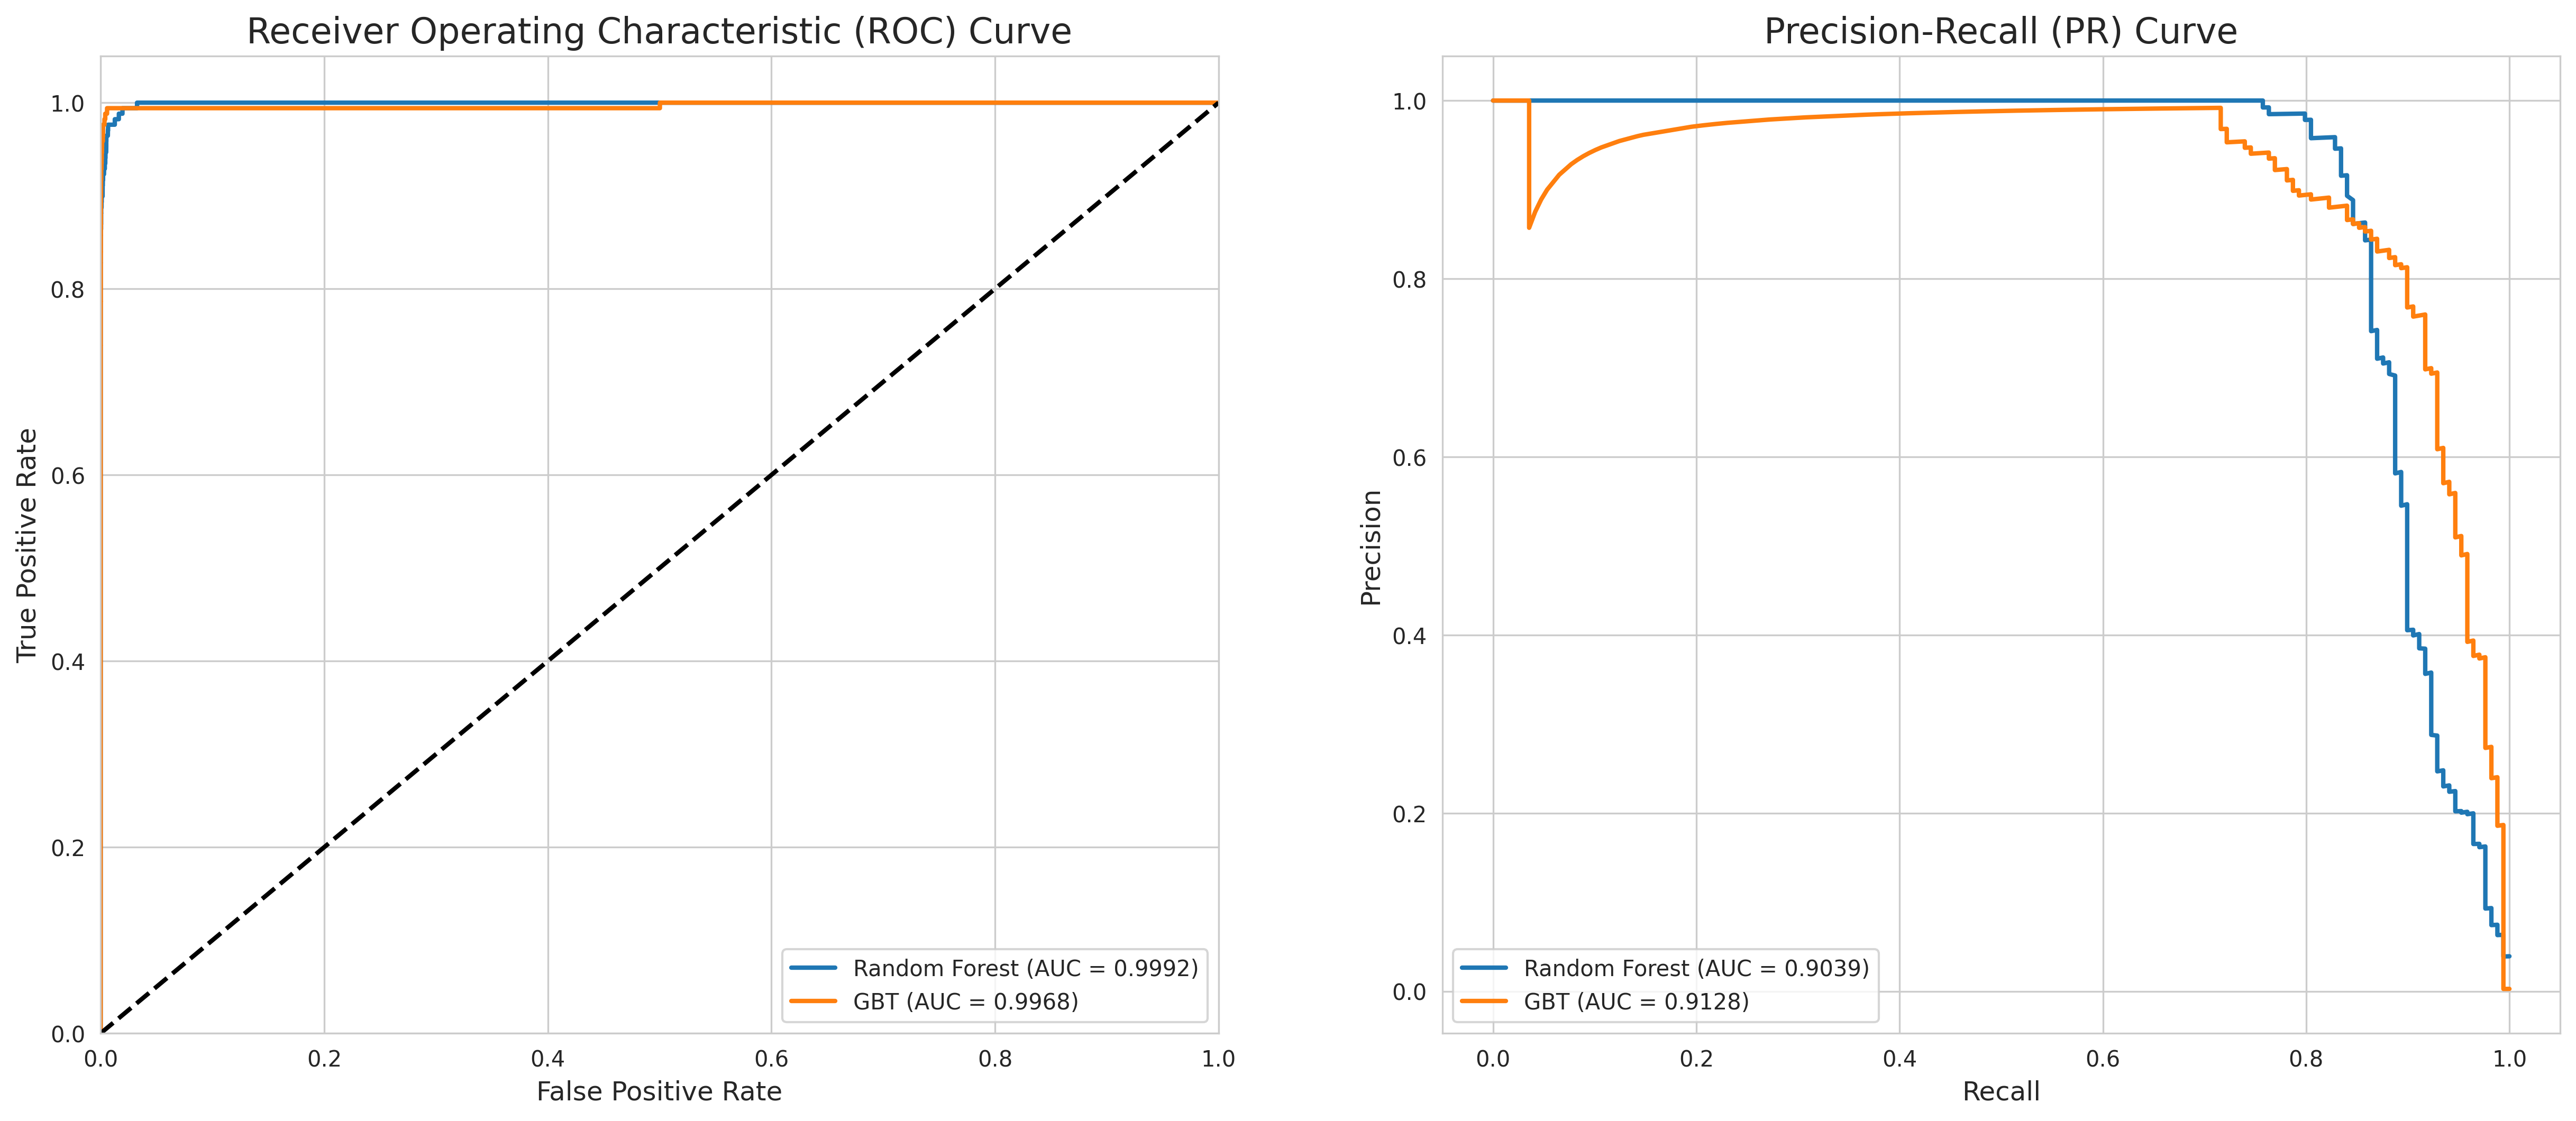

Cell 31: ROC and PR curves generated.


In [31]:
# Cell 31: Section 7 (Evaluation) - ROC and PR Curves
#
# This requires collecting probabilities. We will sample the test set
# to avoid OOM errors on the driver.
#

def plot_roc_pr_curves(predictions_list, model_names):
    """
    Plots ROC and PR curves for a list of models on one chart.
    """
    try:
        log.info("Plotting ROC and PR curves...")
        
        plt.figure(figsize=(20, 8))
        
        # --- 1. ROC Curve Plot ---
        plt.subplot(1, 2, 1)
        
        for i, predictions in enumerate(predictions_list):
            model_name = model_names[i]
            
            # Extract probability for class 1
            # We must sample to avoid OOM
            preds_sample_pd = predictions.select(
                "label", 
                "probability"
            ).sample(0.1, seed=42).toPandas()
            
            # Extract prob of "1" (fraud)
            y_prob = [p[1] for p in preds_sample_pd['probability']]
            y_true = preds_sample_pd['label']
            
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc_val = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc_val:.4f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
        plt.legend(loc="lower right")

        # --- 2. PR Curve Plot ---
        plt.subplot(1, 2, 2)
        
        for i, predictions in enumerate(predictions_list):
            model_name = model_names[i]
            
            preds_sample_pd = predictions.select(
                "label", 
                "probability"
            ).sample(0.1, seed=42).toPandas()
            
            y_prob = [p[1] for p in preds_sample_pd['probability']]
            y_true = preds_sample_pd['label']
            
            precision, recall, _ = precision_recall_curve(y_true, y_prob)
            pr_auc_val = average_precision_score(y_true, y_prob)
            
            plt.plot(recall, precision, lw=2, label=f'{model_name} (AUC = {pr_auc_val:.4f})')
        
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall (PR) Curve', fontsize=16)
        plt.legend(loc="lower left")

        # --- Save and Show ---
        plot_path = os.path.join(PLOT_OUTPUT_DIR, '07_roc_pr_curves.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        log.info(f"Saved ROC and PR curve plot to {plot_path}")
        
        plt.show()

    except Exception as e:
        log.error(f"Error plotting ROC/PR curves: {e}")
        import traceback
        log.error(traceback.format_exc())

try:
    # Plot for RF and GBT if they exist (IF doesn't have probabilities)
    valid_predictions = []
    valid_names = []
    
    if 'rf_predictions' in globals() and 'probability' in rf_predictions.columns:
        valid_predictions.append(rf_predictions)
        valid_names.append("Random Forest")
    else:
        log.warning("RF predictions or probability column not found.")
        
    if 'gbt_predictions' in globals() and 'probability' in gbt_predictions.columns:
        valid_predictions.append(gbt_predictions)
        valid_names.append("GBT")
    else:
        log.warning("GBT predictions or probability column not found.")
    
    if valid_predictions:
        plot_roc_pr_curves(valid_predictions, valid_names)
    else:
        log.warning("No valid predictions with probability columns found. Skipping ROC/PR curves.")

except Exception as e:
    log.error(f"Error in ROC/PR curve plotting: {e}")

print("="*80)
print("Cell 31: ROC and PR curves generated.")
print("="*80)

In [32]:
# Cell 32: Section 8 (Advanced) - Identify Repeat Fraudsters
#
# Use Hive SQL to find accounts ('nameOrig') that have
# committed more than one fraudulent transaction.
#

try:
    log.info("Analyzing for repeat fraudulent senders...")
    
    sql_query = f"""
    SELECT 
        nameOrig, 
        SUM(isFraud) as total_fraud_transactions,
        SUM(amount) as total_fraud_amount,
        COUNT(*) as total_transactions
    FROM {HIVE_TABLE_NAME}
    WHERE isFraud = 1
    GROUP BY nameOrig
    HAVING total_fraud_transactions > 1
    ORDER BY total_fraud_transactions DESC, total_fraud_amount DESC
    """
    
    repeat_fraudsters_df = spark.sql(sql_query)
    
    log.info("Top Repeat Fraudsters (Senders):")
    repeat_fraudsters_df.show()
    
    log.info(f"Found {repeat_fraudsters_df.count()} accounts that sent > 1 fraudulent transaction.")
    
except Exception as e:
    log.error(f"Error identifying repeat fraudsters: {e}")

print("="*80)
print("Cell 32: Repeat fraudster analysis complete.")
print("="*80)

2025-11-16 19:36:29 - FraudDetectionLogger - INFO - Analyzing for repeat fraudulent senders...
2025-11-16 19:36:29 - FraudDetectionLogger - INFO - Top Repeat Fraudsters (Senders):


+--------+------------------------+------------------+------------------+
|nameOrig|total_fraud_transactions|total_fraud_amount|total_transactions|
+--------+------------------------+------------------+------------------+
+--------+------------------------+------------------+------------------+



2025-11-16 19:36:34 - FraudDetectionLogger - INFO - Found 0 accounts that sent > 1 fraudulent transaction.


Cell 32: Repeat fraudster analysis complete.


In [33]:
# Cell 33: Section 8 (Advanced) - Fraud by Amount Ranges

try:
    log.info("Analyzing fraud patterns by transaction amount range...")
    
    sql_query = f"""
    SELECT 
        CASE
            WHEN amount < 1000 THEN '1. < 1K'
            WHEN amount BETWEEN 1000 AND 10000 THEN '2. 1K - 10K'
            WHEN amount BETWEEN 10000 AND 100000 THEN '3. 10K - 100K'
            WHEN amount BETWEEN 100000 AND 1000000 THEN '4. 100K - 1M'
            ELSE '5. > 1M'
        END as amount_range,
        SUM(isFraud) as total_fraud,
        COUNT(*) as total_transactions,
        (SUM(isFraud) / COUNT(*)) * 100 as fraud_rate_in_range
    FROM {HIVE_TABLE_NAME}
    GROUP BY amount_range
    ORDER BY amount_range
    """
    
    amount_range_df = spark.sql(sql_query)
    
    log.info("Fraud Statistics by Amount Range:")
    amount_range_df.show()

except Exception as e:
    log.error(f"Error analyzing fraud by amount ranges: {e}")

print("="*80)
print("Cell 33: Fraud by amount range analysis complete.")
print("="*80)

2025-11-16 19:36:34 - FraudDetectionLogger - INFO - Analyzing fraud patterns by transaction amount range...
2025-11-16 19:36:34 - FraudDetectionLogger - INFO - Fraud Statistics by Amount Range:
[Stage 213:>                                                      (0 + 12) / 12]

+-------------+-----------+------------------+-------------------+
| amount_range|total_fraud|total_transactions|fraud_rate_in_range|
+-------------+-----------+------------------+-------------------+
|      1. < 1K|         58|            142642|0.04066123582114665|
|  2. 1K - 10K|        220|           1143449|0.01924003606632215|
|3. 10K - 100K|       1429|           2239207|0.06381723529803185|
| 4. 100K - 1M|       3800|           2706696|0.14039256717414886|
|      5. > 1M|       2706|            130626| 2.0715630885122414|
+-------------+-----------+------------------+-------------------+

Cell 33: Fraud by amount range analysis complete.


2025-11-16 19:36:36 - FraudDetectionLogger - INFO - Generating hourly transaction heatmap data...
2025-11-16 19:36:38 - FraudDetectionLogger - INFO - Saved total transactions heatmap to /home/smitvd22/SparkProject/output/plots/08_heatmap_total.png


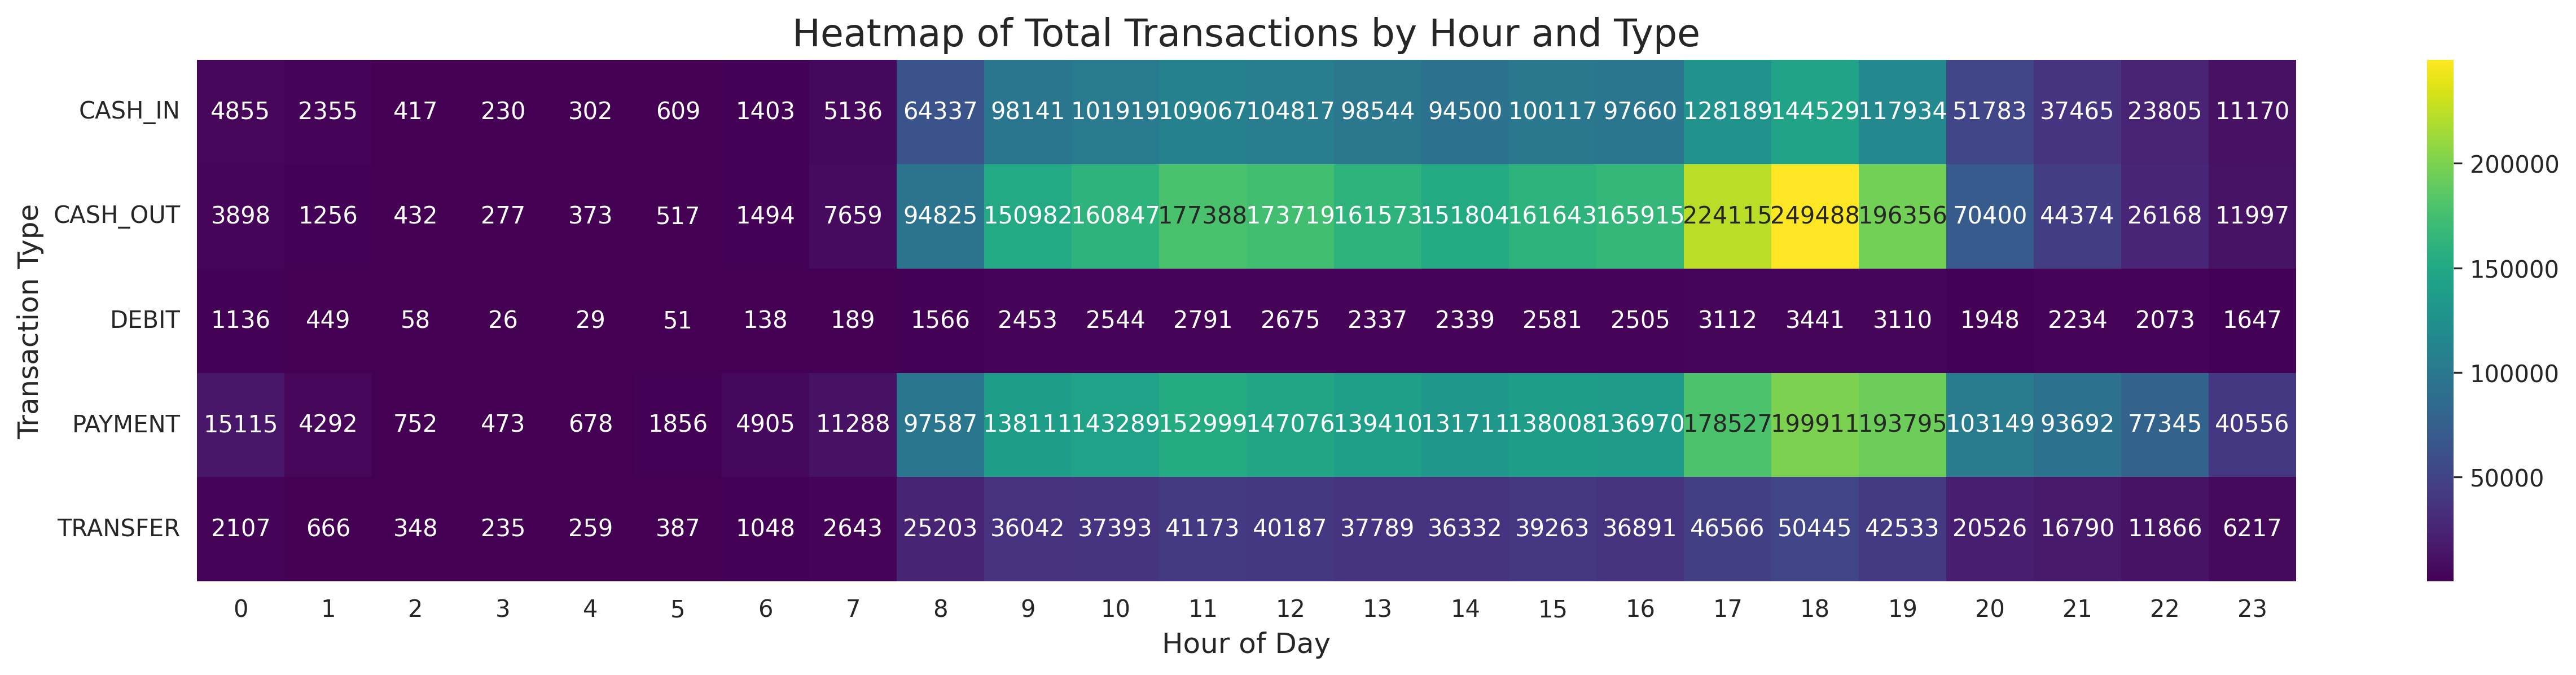

2025-11-16 19:36:40 - FraudDetectionLogger - INFO - Saved fraud transactions heatmap to /home/smitvd22/SparkProject/output/plots/09_heatmap_fraud.png


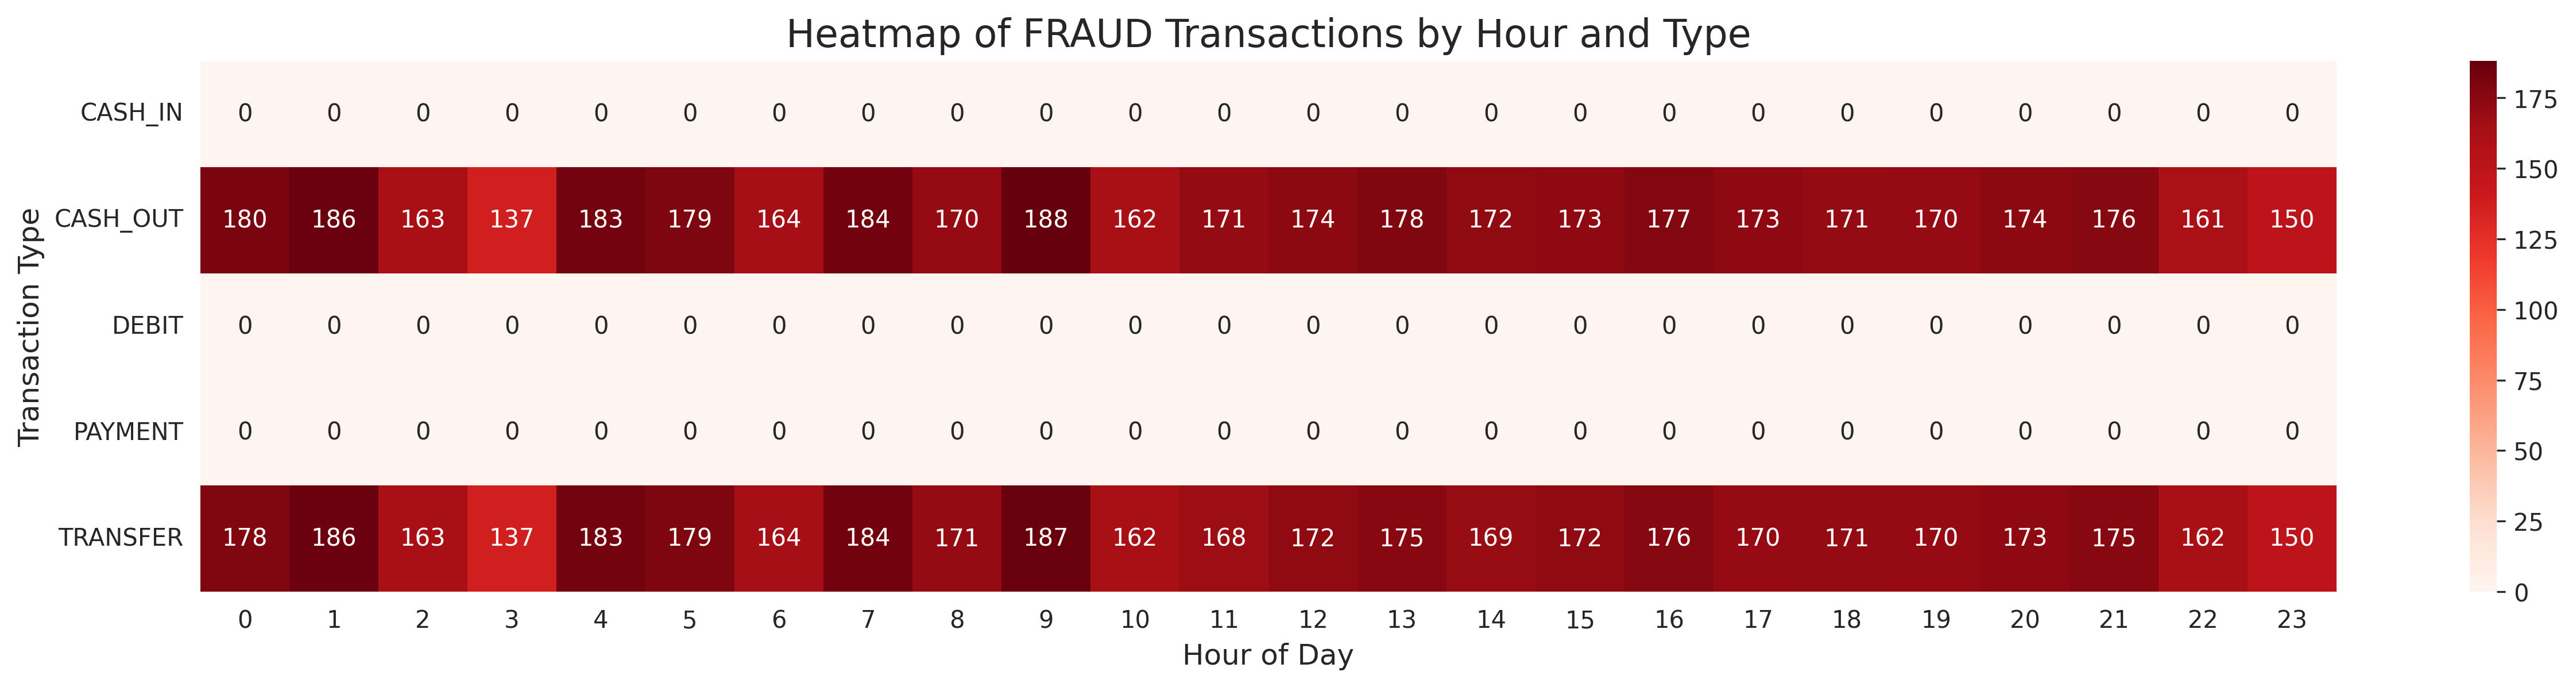

Cell 34: Transaction heatmap analysis complete.


In [34]:
# Cell 34: Section 9 (Time-Series) - Hourly Fraud Heatmap
#
# Use a SQL query to create a heatmap of transactions
# by 'hour_of_day' and 'type'.
#

try:
    log.info("Generating hourly transaction heatmap data...")
    
    # We use the 'transactions_with_time' view from Cell 18
    sql_query = f"""
    SELECT 
        hour_of_day,
        type,
        COUNT(*) as num_transactions,
        SUM(isFraud) as num_fraud
    FROM transactions_with_time
    GROUP BY hour_of_day, type
    """
    
    heatmap_df = spark.sql(sql_query)
    heatmap_pd = heatmap_df.toPandas()
    
    # --- Plot 1: Total Transactions ---
    heatmap_total_pd = heatmap_pd.pivot(
        index="type", 
        columns="hour_of_day", 
        values="num_transactions"
    ).fillna(0)
    
    plt.figure(figsize=(20, 4))
    sns.heatmap(heatmap_total_pd, annot=True, fmt='g', cmap='viridis')
    plt.title('Heatmap of Total Transactions by Hour and Type', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Transaction Type', fontsize=12)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '08_heatmap_total.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved total transactions heatmap to {plot_path}")
    plt.show()

    # --- Plot 2: Fraud Transactions ---
    heatmap_fraud_pd = heatmap_pd.pivot(
        index="type", 
        columns="hour_of_day", 
        values="num_fraud"
    ).fillna(0)
    
    plt.figure(figsize=(20, 4))
    sns.heatmap(heatmap_fraud_pd, annot=True, fmt='g', cmap='Reds')
    plt.title('Heatmap of FRAUD Transactions by Hour and Type', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Transaction Type', fontsize=12)
    
    plot_path = os.path.join(PLOT_OUTPUT_DIR, '09_heatmap_fraud.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    log.info(f"Saved fraud transactions heatmap to {plot_path}")
    plt.show()
    
except Exception as e:
    log.error(f"Error generating transaction heatmaps: {e}")

print("="*80)
print("Cell 34: Transaction heatmap analysis complete.")
print("="*80)

In [35]:
# Cell 35: Section 9 (Model Summary) - Model Storage Summary
#
# Summary of where models are saved (models are already saved in cells 24-25).
# No need to save again - just show the current model locations.
#

try:
    log.info("Model Storage Summary:")
    
    # --- 1. Check Random Forest Model ---
    rf_model_path = os.path.join(MODEL_OUTPUT_DIR, 'random_forest_model')
    if os.path.exists(rf_model_path):
        log.info(f"✓ Random Forest model saved at: {rf_model_path}")
    else:
        log.warning(f"✗ Random Forest model not found at: {rf_model_path}")
    
    # --- 2. Check GBT Model ---
    gbt_model_path = os.path.join(MODEL_OUTPUT_DIR, 'gbt_model')
    if os.path.exists(gbt_model_path):
        log.info(f"✓ GBT model saved at: {gbt_model_path}")
    else:
        log.warning(f"✗ GBT model not found at: {gbt_model_path}")
    
    # --- 3. Save Preprocessing Pipeline (if needed) ---
    preproc_path = os.path.join(MODEL_OUTPUT_DIR, "preprocessing_pipeline")
    if not os.path.exists(preproc_path):
        log.info("Saving preprocessing pipeline for standalone use...")
        
        # Reload the data it was trained on
        temp_df = spark.read.parquet(HDFS_DATA_PATH).drop('nameOrig', 'nameDest', 'isFlaggedFraud')
        temp_df_with_time = temp_df.withColumn("hour_of_day", (col("step") - 1) % 24)
        
        # Define pipeline
        preproc_pipeline = Pipeline(
            stages=[type_indexer, type_encoder, assembler, scaler]
        )
        # Fit and save
        preproc_model_to_save = preproc_pipeline.fit(temp_df_with_time)
        preproc_model_to_save.write().overwrite().save(f"file://{preproc_path}")
        
        log.info(f"✓ Preprocessing pipeline saved at: {preproc_path}")
    else:
        log.info(f"✓ Preprocessing pipeline already exists at: {preproc_path}")


except Exception as e:
    log.error(f"Error checking/saving models: {e}")
    
print("="*80)
print("Cell 35: Model storage summary complete.")
print("="*80)

2025-11-16 19:36:40 - FraudDetectionLogger - INFO - Model Storage Summary:
2025-11-16 19:36:40 - FraudDetectionLogger - INFO - ✓ Random Forest model saved at: /home/smitvd22/SparkProject/models/random_forest_model
2025-11-16 19:36:40 - FraudDetectionLogger - INFO - ✓ GBT model saved at: /home/smitvd22/SparkProject/models/gbt_model
2025-11-16 19:36:40 - FraudDetectionLogger - INFO - ✓ Preprocessing pipeline already exists at: /home/smitvd22/SparkProject/models/preprocessing_pipeline


Cell 35: Model storage summary complete.


In [36]:
# Cell 36: Section 9 (Model Loading/Prediction) - Demo
#
# Demonstrate how to load the models and make a prediction using the correct model classes.
#

try:
    log.info("--- Model Loading and Prediction Demo ---")
    
    # --- 1. Load Models from correct paths with correct classes ---
    rf_model_path = f"file://{MODEL_OUTPUT_DIR}/random_forest_model"
    gbt_model_path = f"file://{MODEL_OUTPUT_DIR}/gbt_model"
    
    # Check which models are available
    available_models = []
    if os.path.exists(os.path.join(MODEL_OUTPUT_DIR, 'random_forest_model')):
        available_models.append(('Random Forest', rf_model_path, 'rf'))
    if os.path.exists(os.path.join(MODEL_OUTPUT_DIR, 'gbt_model')):
        available_models.append(('GBT', gbt_model_path, 'gbt'))
    
    if available_models:
        log.info(f"Found {len(available_models)} trained models")
        
        # Load the GBT model (preferred) or Random Forest if available
        if any('GBT' in model[0] for model in available_models):
            model_name, model_path, model_type = next(model for model in available_models if 'GBT' in model[0])
        else:
            model_name, model_path, model_type = available_models[0]
            
        log.info(f"Loading {model_name} model from: {model_path}")
        
        # Load with the correct model class
        if model_type == 'rf':
            from pyspark.ml.classification import RandomForestClassificationModel
            loaded_model = RandomForestClassificationModel.load(model_path)
        elif model_type == 'gbt':
            from pyspark.ml.classification import GBTClassificationModel
            loaded_model = GBTClassificationModel.load(model_path)
        
        # --- 2. Load Sample Data for Prediction ---
        log.info("Loading sample data from test set...")
        test_df = spark.read.parquet(HDFS_TEST_PATH)
        
        # Get one fraud and one normal transaction
        sample_fraud = test_df.filter("label = 1").limit(1)
        sample_normal = test_df.filter("label = 0").limit(1)
        
        if sample_fraud.count() > 0 and sample_normal.count() > 0:
            sample_data = sample_fraud.union(sample_normal)
            
            log.info(f"Making predictions with {model_name} model...")
            predictions = loaded_model.transform(sample_data)
            
            print(f"\n--- {model_name} Model Predictions ---")
            predictions.select(
                "label", "prediction", "probability"
            ).show(truncate=False)
            
            # Show some feature information too
            print("\n--- Sample Features (first 10 values) ---")
            features_row = predictions.select("features").collect()[0]
            feature_values = features_row['features'].toArray()
            print(f"Features vector size: {len(feature_values)}")
            print(f"First 10 feature values: {feature_values[:10]}")
            
            # Show model type for reference
            print(f"\n--- Model Information ---")
            print(f"Model Type: {model_name}")
            print(f"Model Class: {type(loaded_model).__name__}")
            
        else:
            log.warning("Could not find both fraud and normal samples in test data")
    else:
        log.warning("No trained models found. Please run cells 24-25 first to train models.")
        log.info("Expected model locations:")
        log.info(f"  - Random Forest: {os.path.join(MODEL_OUTPUT_DIR, 'random_forest_model')}")
        log.info(f"  - GBT: {os.path.join(MODEL_OUTPUT_DIR, 'gbt_model')}")
    
except Exception as e:
    log.error(f"Error in model loading/prediction demo: {e}")
    import traceback
    log.error(traceback.format_exc())

print("="*80)
print("Cell 36: Model loading and prediction demo complete.")
print("="*80)

2025-11-16 19:36:40 - FraudDetectionLogger - INFO - --- Model Loading and Prediction Demo ---
2025-11-16 19:36:40 - FraudDetectionLogger - INFO - Found 2 trained models
2025-11-16 19:36:40 - FraudDetectionLogger - INFO - Loading GBT model from: file:///home/smitvd22/SparkProject/models/gbt_model
2025-11-16 19:36:42 - FraudDetectionLogger - INFO - Loading sample data from test set...
2025-11-16 19:36:44 - FraudDetectionLogger - INFO - Making predictions with GBT model...



--- GBT Model Predictions ---


+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|1    |1.0       |[0.02131260090671402,0.978687399093286] |
|0    |0.0       |[0.9784749749628214,0.02152502503717857]|
+-----+----------+----------------------------------------+


--- Sample Features (first 10 values) ---


[Stage 242:==================================================>    (11 + 1) / 12]

Features vector size: 12
First 10 feature values: [-0.73648379 -0.71477782 -0.5309652   3.3074779  -0.08095964 -1.70304144
 -0.23978852 -0.2765763  -0.29244168 -0.32381387]

--- Model Information ---
Model Type: GBT
Model Class: GBTClassificationModel
Cell 36: Model loading and prediction demo complete.


In [37]:
# Cell 37: Section 10 - Shutdown
#
# Stop the SparkSession and clean up intermediate HDFS files.
#

try:
    log.info("Cleaning up and stopping SparkSession...")
    
    # --- *** MODIFICATION: Remove all .unpersist() calls *** ---
    
    # --- *** NEW: Delete intermediate HDFS files *** ---
    log.info("Deleting intermediate HDFS files...")
    
    # Get the Hadoop FileSystem object
    fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
    
    # Create Path objects
    path_processed = spark._jvm.org.apache.hadoop.fs.Path(HDFS_PROCESSED_PATH)
    path_unbalanced_train = spark._jvm.org.apache.hadoop.fs.Path(HDFS_UNBALANCED_TRAIN_PATH)
    path_test = spark._jvm.org.apache.hadoop.fs.Path(HDFS_TEST_PATH)
    path_train = spark._jvm.org.apache.hadoop.fs.Path(HDFS_TRAIN_PATH)
    
    # Delete them (recursive=True)
    if fs.exists(path_processed):
        fs.delete(path_processed, True)
        log.info(f"Deleted: {HDFS_PROCESSED_PATH}")
        
    if fs.exists(path_unbalanced_train):
        fs.delete(path_unbalanced_train, True)
        log.info(f"Deleted: {HDFS_UNBALANCED_TRAIN_PATH}")
        
    if fs.exists(path_test):
        fs.delete(path_test, True)
        log.info(f"Deleted: {HDFS_TEST_PATH}")
        
    if fs.exists(path_train):
        fs.delete(path_train, True)
        log.info(f"Deleted: {HDFS_TRAIN_PATH}")
    
    log.info("All intermediate HDFS files deleted.")
    
    # Stop the Spark context
    spark.stop()
    
    log.info("SparkSession stopped. Notebook execution complete.")

except Exception as e:
    log.error(f"Error during Spark shutdown: {e}")

print("="*80)
print("Cell 37: SparkSession stopped. Project complete.")
print("="*80)

2025-11-16 19:36:51 - FraudDetectionLogger - INFO - Cleaning up and stopping SparkSession...
2025-11-16 19:36:51 - FraudDetectionLogger - INFO - Deleting intermediate HDFS files...
2025-11-16 19:36:51 - FraudDetectionLogger - INFO - Deleted: /user/smitvd22/fraud_detection/intermediate/processed.parquet
2025-11-16 19:36:51 - FraudDetectionLogger - INFO - Deleted: /user/smitvd22/fraud_detection/intermediate/unbalanced_train.parquet
2025-11-16 19:36:51 - FraudDetectionLogger - INFO - Deleted: /user/smitvd22/fraud_detection/intermediate/test.parquet
2025-11-16 19:36:51 - FraudDetectionLogger - INFO - Deleted: /user/smitvd22/fraud_detection/intermediate/train_balanced.parquet
2025-11-16 19:36:51 - FraudDetectionLogger - INFO - All intermediate HDFS files deleted.
2025-11-16 19:36:54 - FraudDetectionLogger - INFO - SparkSession stopped. Notebook execution complete.


Cell 37: SparkSession stopped. Project complete.
